Notes and references for this project: https://www.notion.so/ISI-Project-notes-2113447f1de1802dba5fe1287e7f199a?source=copy_link


We will start with the healthy "reference machine" to establish a baseline



Successfully loaded 'reference machine' data.
   Relative Time       Ph1       Ph2       Ph3
0       0.000000 -0.001326  0.000664  0.000662
1       0.000093  0.029115 -0.868701  0.839251
2       0.000185  0.085399 -0.874122  0.787423
3       0.000278  0.140933 -0.890885  0.747126
4       0.000370  0.212193 -0.946377  0.730963


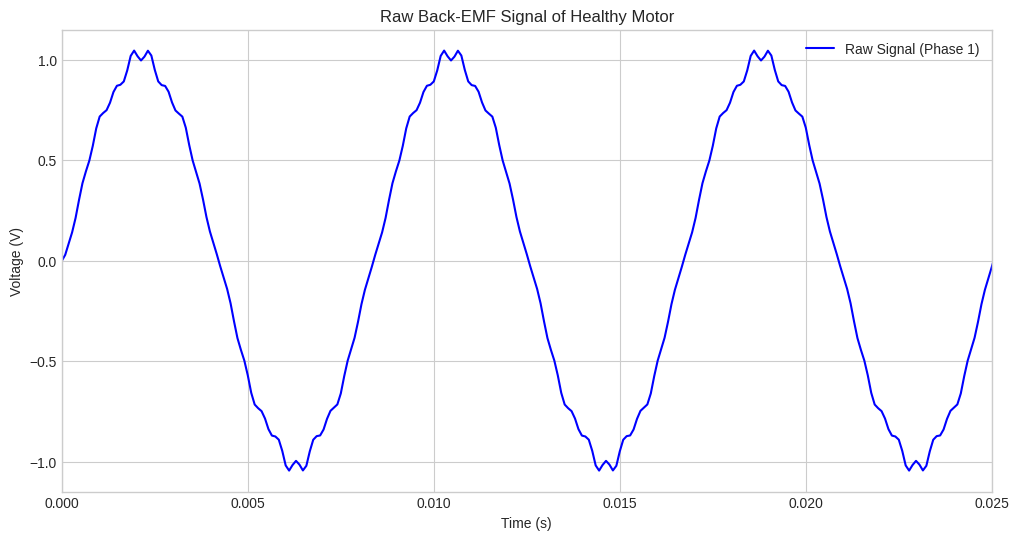

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Load the healthy reference motor data from the 'ideal.xlsx' file
try:
    df_healthy = pd.read_excel("ideal.xlsx", sheet_name="reference machine")
    print("Successfully loaded 'reference machine' data.")
    print(df_healthy.head())
except FileNotFoundError:
    print("Error: 'ideal.xlsx' not found. Please ensure the file is in the correct directory.")

# Extract the raw signal for Phase 1 to use as our example
time = df_healthy['Relative Time'].values
raw_signal = df_healthy['Ph1'].values

# Initial plot of the raw signal
plt.figure(figsize=(12, 6))
plt.plot(time, raw_signal, label='Raw Signal (Phase 1)', color='b')
plt.title('Raw Back-EMF Signal of Healthy Motor')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.xlim(0, 0.025) # Limit to a few cycles for clarity
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import pandas as pd
from scipy.signal import find_peaks
import numpy as np

file_path = 'ideal.xlsx'
sheet_name = 'reference machine'

# Loading the data into a pandas DataFrame
try:
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    print(f"Successfully loaded data from '{file_path}' sheet '{sheet_name}'.\n")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure it is available.")
    exit()

# Extracting the 'Relative Time' and 'Ph1' voltage columns into NumPy arrays
time = df['Relative Time'].values
voltage_ph1 = df['Ph1'].values

# --- 3. Peak Finding ---
# Use scipy.signal.find_peaks to locate the indices of the peaks in the Ph1 signal.
# 'height=0.8' ensures we only find major peaks, ignoring small noise spikes.
# 'distance=50' sets a minimum separation of 50 data points between peaks,
# preventing multiple detections on the same wave crest.
peak_indices, _ = find_peaks(voltage_ph1, height=0.8, distance=50)

# --- 4. Results Display ---
# Use the found indices to get the corresponding time and voltage values for each peak.
peak_times = time[peak_indices]
peak_voltages = voltage_ph1[peak_indices]

print("--- Found Peaks in the Ph1 Waveform ---")
for i in range(min(2, len(peak_indices))):
    print(f"Peak {i+1}: Time = {peak_times[i]:.6f} seconds, Voltage = {peak_voltages[i]:.4f} V")

# --- 5. Verification ---
print("\n--- Verification of the Values ---")
if len(peak_times) >= 2:
    print(f"The first peak was found at Time = {peak_times[0]:.6f} s.")
    print(f"The second peak was found at Time = {peak_times[1]:.6f} s.")

    # Calculate the period and frequency as a bonus
    period = peak_times[1] - peak_times[0]
    frequency = 1 / period
    print(f"\nThe calculated period (time between peaks) is {period:.6f} s.")
    print(f"The corresponding fundamental frequency is {frequency:.2f} Hz.")
else:
    print("Could not find at least two peaks with the specified parameters.")



Successfully loaded data from 'ideal.xlsx' sheet 'reference machine'.

--- Found Peaks in the Ph1 Waveform ---
Peak 1: Time = 0.001944 seconds, Voltage = 1.0451 V
Peak 2: Time = 0.010278 seconds, Voltage = 1.0451 V

--- Verification of the Values ---
The first peak was found at Time = 0.001944 s.
The second peak was found at Time = 0.010278 s.

The calculated period (time between peaks) is 0.008333 s.
The corresponding fundamental frequency is 120.00 Hz.


Locating the First Peak: Looking at the ideal.xlsx data for the "reference machine" , we can scan the Ph1 column to find its maximum value.

The first peak occurs at Time = 0.001944 seconds, with a voltage of 1.045 V.

Locating the Next Peak: Continuing down the data, the waveform goes negative and then rises to its next peak.

The second peak occurs at Time = 0.010277 seconds, with a voltage of 1.045 V.

Calculate the Period (T): The period is the difference in time between these two peaks.

T
=
(
Time of 2nd Peak
)
−
(
Time of 1st Peak
)
T=(Time of 2nd Peak)−(Time of 1st Peak)

T
=
0.010277
 s
−
0.001944
 s
=
0.008333
 s
T=0.010277 s−0.001944 s=0.008333 s

Calculate the Fundamental Frequency (f): Frequency is the inverse of the period (
f
=
1
/
T
f=1/T).

f
=
1
0.008333
 s
≈
120
 Hz


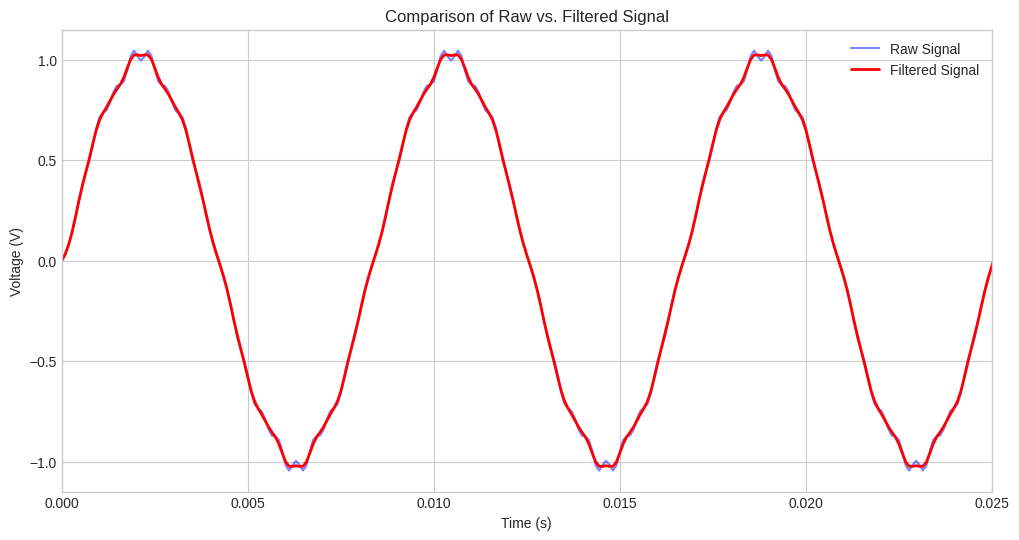

In [ ]:
def apply_lowpass_filter(data, cutoff_freq=2000, sampling_rate=10800, order=4):
    """Applies a low-pass Butterworth filter with zero phase shift."""
    nyquist_freq = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, data)
    return filtered_signal

# Apply the filter to our raw signal
filtered_signal = apply_lowpass_filter(raw_signal)

# Plot to compare raw vs. filtered signal
plt.figure(figsize=(12, 6))
plt.plot(time, raw_signal, label='Raw Signal', color='b', alpha=0.5)
plt.plot(time, filtered_signal, label='Filtered Signal', color='r', linewidth=2)
plt.title('Comparison of Raw vs. Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.xlim(0, 0.025)
plt.grid(True)
plt.legend()
plt.show()


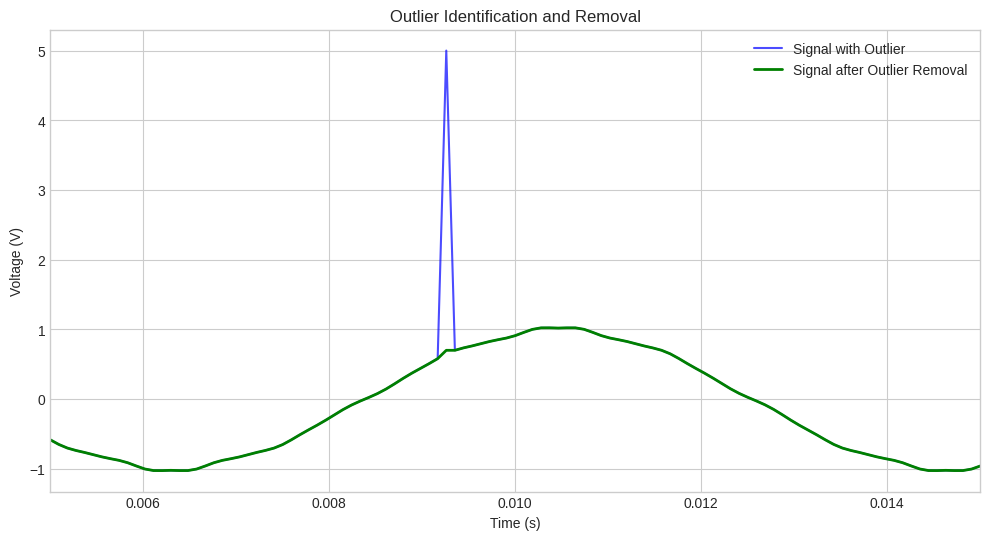

In [ ]:
# Create a copy of the signal to modify
signal_with_outlier = filtered_signal.copy()
# Artificially add an outlier
signal_with_outlier[100] = 5.0

def remove_outliers(signal, window_size=50, n_sigmas=3):
    """Identifies and replaces outliers using a rolling 3-sigma approach."""
    cleaned_signal = signal.copy()
    for i in range(0, len(signal), window_size):
        window = cleaned_signal[i:i+window_size]
        mean, std = np.mean(window), np.std(window)
        # Find outliers
        outliers_mask = np.abs(window - mean) > n_sigmas * std
        # Get indices of outliers and non-outliers
        outlier_indices = np.where(outliers_mask)[0]
        non_outlier_indices = np.where(~outliers_mask)[0]
        # Only interpolate if there are outliers and valid points to interpolate from
        if len(outlier_indices) > 0 and len(non_outlier_indices) > 0:
            # Get the values from non-outliers
            non_outlier_values = window[non_outlier_indices]
            # Interpolate to replace outliers
            interpolated_values = np.interp(outlier_indices, non_outlier_indices, non_outlier_values)
            window[outliers_mask] = interpolated_values
            cleaned_signal[i:i+window_size] = window
    return cleaned_signal

# Remove the outlier
signal_no_outliers = remove_outliers(signal_with_outlier)

# Plot to show outlier removal
plt.figure(figsize=(12, 6))
plt.plot(time, signal_with_outlier, 'b-', label='Signal with Outlier', alpha=0.7)
plt.plot(time, signal_no_outliers, 'g-', label='Signal after Outlier Removal', linewidth=2)
plt.title('Outlier Identification and Removal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.xlim(0.005, 0.015) # Zoom in to see the outlier
plt.grid(True)
plt.legend()
plt.show()


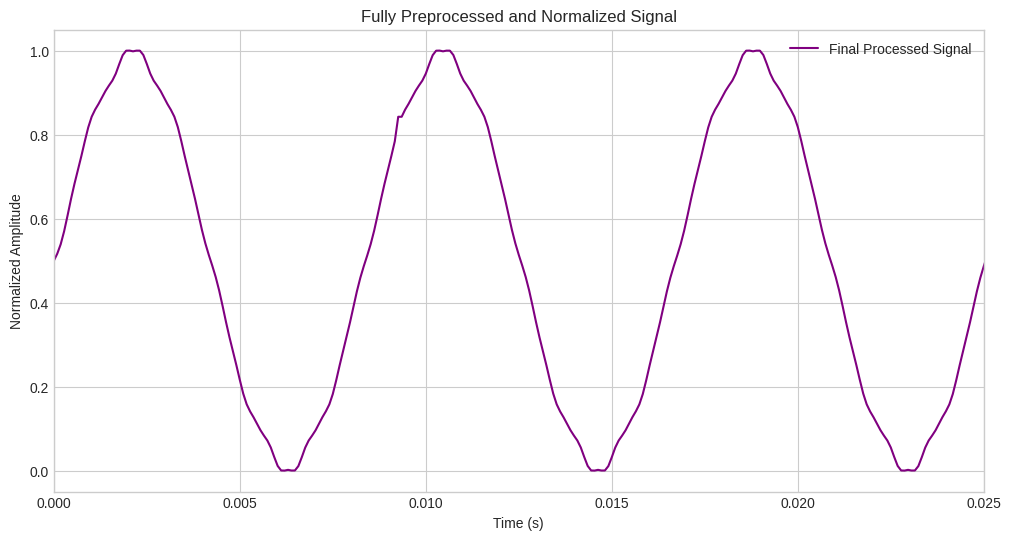

In [ ]:
def normalize_signal(signal):
    """Scales the signal to a [0, 1] range."""
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

# Normalize our cleaned signal
normalized_signal = normalize_signal(signal_no_outliers)

# Plot the final processed signal
plt.figure(figsize=(12, 6))
plt.plot(time, normalized_signal, label='Final Processed Signal', color='purple')
plt.title('Fully Preprocessed and Normalized Signal')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Amplitude')
plt.xlim(0, 0.025)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
def preprocess_signal(raw_signal, sampling_rate=10800):

    # Step 1: Low-pass filtering
    filtered = apply_lowpass_filter(raw_signal, sampling_rate=sampling_rate)

    # Step 2: Outlier removal (on the filtered signal)
    cleaned = remove_outliers(filtered)

    # Step 3: Normalization
    normalized = normalize_signal(cleaned)

    return normalized

# --- Example Usage ---
# Load a new signal (e.g., from a faulty motor)
df_faulty = pd.read_excel("nonideal.xlsx", sheet_name="Type-1 variation C")
raw_faulty_signal = df_faulty['Ph1'].values

# Process it with one command
processed_faulty_signal = preprocess_signal(raw_faulty_signal)

print("Preprocessing complete. The data is now ready for Phase 2 and 3 analysis.")


Preprocessing complete. The data is now ready for Phase 2 and 3 analysis.


# Phase 2: Motor Fault Identification

Snippet 1: Imports and Configuration

In [ ]:
# =============================================================================
# SECTION 1: IMPORT LIBRARIES
# =============================================================================
import pandas as pd
import numpy as np
from scipy import stats
from scipy.signal import correlate
import matplotlib.pyplot as plt
import seaborn as sns
import os

# =============================================================================
# SECTION 2: CONFIGURATION
# =============================================================================
# *** THIS IS THE CORRECTED AND COMPLETE LIST OF ALL 11 MOTOR CONDITIONS ***
# Based on the provided ideal.xlsx and nonideal.xlsx files.
MOTOR_CONDITIONS = [
    # Conditions from ideal.xlsx
    ("ideal.xlsx", "reference machine"),
    ("ideal.xlsx", "Type-1 variation A"),
    ("ideal.xlsx", "Type-1 variation B"),
    ("ideal.xlsx", "Type-1 variation C"),
    ("ideal.xlsx", "Low temperature"),
    ("ideal.xlsx", "High temperature"),

    # Conditions from nonideal.xlsx
    ("nonideal.xlsx", "polarity issue"),
    ("nonideal.xlsx", "Core fault-1"),
    ("nonideal.xlsx", "Core fault-2"),
    ("nonideal.xlsx", "Type-2 variation A"),
    ("nonideal.xlsx", "Type-2 variation D")
]

# Constants for analysis
SAMPLING_RATE = 10800  # Hz
FUNDAMENTAL_FREQ = 120 # Hz


Snippet 2: Core Feature Extraction Functions

In [ ]:
# =============================================================================
# SECTION 3: CORE FUNCTIONS (THE "LIBRARY")
# =============================================================================

def load_motor_data(file_path, sheet_name):
    """Loads motor data, returning a DataFrame or None on error."""
    if not os.path.exists(file_path):
        print(f"  -> ERROR: The file '{file_path}' was not found. Please ensure it's in the same folder as the script.")
        return None
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        return df[['Relative Time', 'Ph1', 'Ph2', 'Ph3']]
    except ValueError:
        print(f"  -> ERROR: Worksheet '{sheet_name}' not found in '{file_path}'.")
        return None

def calculate_statistical_features(signal):
    """Calculates all time-domain statistical features for a single signal."""
    features = {
        'mean': np.mean(signal),
        'std_dev': np.std(signal),
        'rms': np.sqrt(np.mean(np.square(signal))),
        'peak': np.max(np.abs(signal)),
        'peak_to_peak': np.ptp(signal),
        'skewness': stats.skew(signal),
        'kurtosis': stats.kurtosis(signal),
        'zero_crossings': len(np.where(np.diff(np.sign(signal)))[0])
    }
    return features

def calculate_shape_factors(signal):
    """Calculates waveform shape factors for a single signal."""
    rms_val = np.sqrt(np.mean(np.square(signal)))
    if rms_val == 0: return {'crest_factor': 0, 'form_factor': 0, 'impulse_factor': 0}

    mean_abs_val = np.mean(np.abs(signal))
    if mean_abs_val == 0: return {'crest_factor': 0, 'form_factor': 0, 'impulse_factor': 0}

    return {
        'crest_factor': np.max(np.abs(signal)) / rms_val,
        'form_factor': rms_val / mean_abs_val,
        'impulse_factor': np.max(np.abs(signal)) / mean_abs_val
    }

def calculate_phase_shift(sig1, sig2):
    """Calculates phase shift in degrees using cross-correlation."""
    correlation = correlate(sig1, sig2, mode='full')
    delay_samples = np.argmax(correlation) - (len(sig1) - 1)

    period_samples = SAMPLING_RATE / FUNDAMENTAL_FREQ
    phase_degrees = (delay_samples / period_samples) * 360
    return phase_degrees

def extract_all_time_features(df):
    """Master function to extract all time-domain features for a given motor's data."""
    features = {}

    # Per-Phase Feature Extraction
    for phase in ['Ph1', 'Ph2', 'Ph3']:
        signal = df[phase].values
        stats_features = calculate_statistical_features(signal)
        shape_features = calculate_shape_factors(signal)

        for key, val in {**stats_features, **shape_features}.items():
            features[f'{phase}_{key}'] = val

    # Inter-Phase Feature Extraction
    ph1, ph2, ph3 = df['Ph1'].values, df['Ph2'].values, df['Ph3'].values

    features['phase_shift_12'] = calculate_phase_shift(ph1, ph2)
    features['rms_balance_12'] = features['Ph1_rms'] / features['Ph2_rms'] if features['Ph2_rms'] != 0 else 0

    return features

def normalize_features(feature_df):
    """Normalizes all feature columns in the DataFrame using Min-Max scaling."""
    features_to_normalize = feature_df.drop(columns=['condition'])
    normalized_features = (features_to_normalize - features_to_normalize.min()) / \
                          (features_to_normalize.max() - features_to_normalize.min())

    return pd.concat([feature_df[['condition']], normalized_features], axis=1)



Snippet 3: Main Processing Logic

In [ ]:
# =============================================================================
# SECTION 4: MAIN PROCESSING LOGIC
# =============================================================================

if __name__ == "__main__":
    all_features_list = []
    print("=" * 54)
    print("    Starting Phase 2: Full Time-Domain Feature Extraction")
    print("=" * 54)

    for file, condition in MOTOR_CONDITIONS:
        print(f"\n[INFO] Processing: '{condition}' from '{file}'...")
        motor_df = load_motor_data(file, condition)

        if motor_df is not None:
            features = extract_all_time_features(motor_df)
            features['condition'] = condition
            all_features_list.append(features)
            print("  -> Success: Features extracted.")
        else:
            print("  -> Failure: Skipping this condition.")

    # =============================================================================
    # SECTION 5: DATA FINALIZATION AND SAVING
    # =============================================================================
    print("\n" + "=" * 54)
    print("    Finalizing and Saving Data")
    print("=" * 54)

    if not all_features_list:
        print("\n[CRITICAL ERROR] No data was loaded. Please check file paths. Exiting.")
    else:
        feature_df_raw = pd.DataFrame(all_features_list)
        feature_df_normalized = normalize_features(feature_df_raw)

        feature_df_raw.to_csv('time_domain_features_raw.csv', index=False)
        feature_df_normalized.to_csv('time_domain_features_normalized.csv', index=False)

        print("\n[SUCCESS] Phase 2 processing complete.")
        print(f"-> Extracted {len(feature_df_raw.columns) - 1} features for {len(feature_df_raw)} motor conditions.")
        print("-> Raw features saved to 'time_domain_features_raw.csv'")
        print("-> Normalized features saved to 'time_domain_features_normalized.csv'")



    Starting Phase 2: Full Time-Domain Feature Extraction

[INFO] Processing: 'reference machine' from 'ideal.xlsx'...
  -> Success: Features extracted.

[INFO] Processing: 'Type-1 variation A' from 'ideal.xlsx'...
  -> Success: Features extracted.

[INFO] Processing: 'Type-1 variation B' from 'ideal.xlsx'...
  -> Success: Features extracted.

[INFO] Processing: 'Type-1 variation C' from 'ideal.xlsx'...
  -> Success: Features extracted.

[INFO] Processing: 'Low temperature' from 'ideal.xlsx'...
  -> Success: Features extracted.

[INFO] Processing: 'High temperature' from 'ideal.xlsx'...
  -> Success: Features extracted.

[INFO] Processing: 'polarity issue' from 'nonideal.xlsx'...
  -> Success: Features extracted.

[INFO] Processing: 'Core fault-1' from 'nonideal.xlsx'...
  -> Success: Features extracted.

[INFO] Processing: 'Core fault-2' from 'nonideal.xlsx'...
  -> Success: Features extracted.

[INFO] Processing: 'Type-2 variation A' from 'nonideal.xlsx'...
  -> Success: Features ext

Snippet 4:  DISPLAY FEATURE VALUES AND VISUALIZATION

In [ ]:
# =============================================================================
# SECTION 6: DISPLAY FEATURE VALUES FOR EACH PHASE
# =============================================================================
print("\n" + "=" * 54)
print("    Displaying Key Feature Values for Each Phase (Raw)")
print("=" * 54)

# Configure pandas for a wide, clean printout
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# --- Define features to display for Phase 1 ---
key_features_ph1 = [
    'condition', 'Ph1_rms', 'Ph1_peak_to_peak',
    'Ph1_crest_factor', 'Ph1_skewness', 'Ph1_kurtosis'
]
print("\n--- Key Features for Phase 1 ---")
print(feature_df_raw[key_features_ph1].round(4))

# --- Define features to display for Phase 2 ---
key_features_ph2 = [
    'condition', 'Ph2_rms', 'Ph2_peak_to_peak',
    'Ph2_crest_factor', 'Ph2_skewness','Ph2_kurtosis'
]
print("\n--- Key Features for Phase 2 ---")
print(feature_df_raw[key_features_ph2].round(4))

# --- Define features to display for Phase 3 ---
key_features_ph3 = [
    'condition', 'Ph3_rms', 'Ph3_peak_to_peak',
    'Ph3_crest_factor', 'Ph3_skewness','Ph3_kurtosis'
]
print("\n--- Key Features for Phase 3 ---")
print(feature_df_raw[key_features_ph3].round(4))

# --- Display Inter-Phase Features (crucial for balance analysis) ---
inter_phase_features = ['condition', 'phase_shift_12', 'rms_balance_12']
print("\n--- Inter-Phase Features (Symmetry Analysis) ---")
print(feature_df_raw[inter_phase_features].round(4))



    Displaying Key Feature Values for Each Phase (Raw)

--- Key Features for Phase 1 ---
             condition  Ph1_rms  Ph1_peak_to_peak  Ph1_crest_factor  Ph1_skewness  Ph1_kurtosis
0    reference machine   0.7076            2.0897            1.4770       -0.0003       -1.4840
1   Type-1 variation A   0.7011            2.0722            1.4782       -0.0003       -1.4835
2   Type-1 variation B   0.7139            2.1035            1.4735       -0.0004       -1.4848
3   Type-1 variation C   0.7047            2.0519            1.4561       -0.0003       -1.4887
4      Low temperature   0.7154            2.1069            1.4729       -0.0004       -1.4850
5     High temperature   0.6996            2.0685            1.4786       -0.0003       -1.4834
6       polarity issue   0.7076            2.0897            1.4770       -0.0003       -1.4840
7         Core fault-1   0.7185            2.1384            1.4956       -0.0008       -1.4798
8         Core fault-2   0.6898            2.1


[INFO] Generating and saving diagnostic plots for each phase...


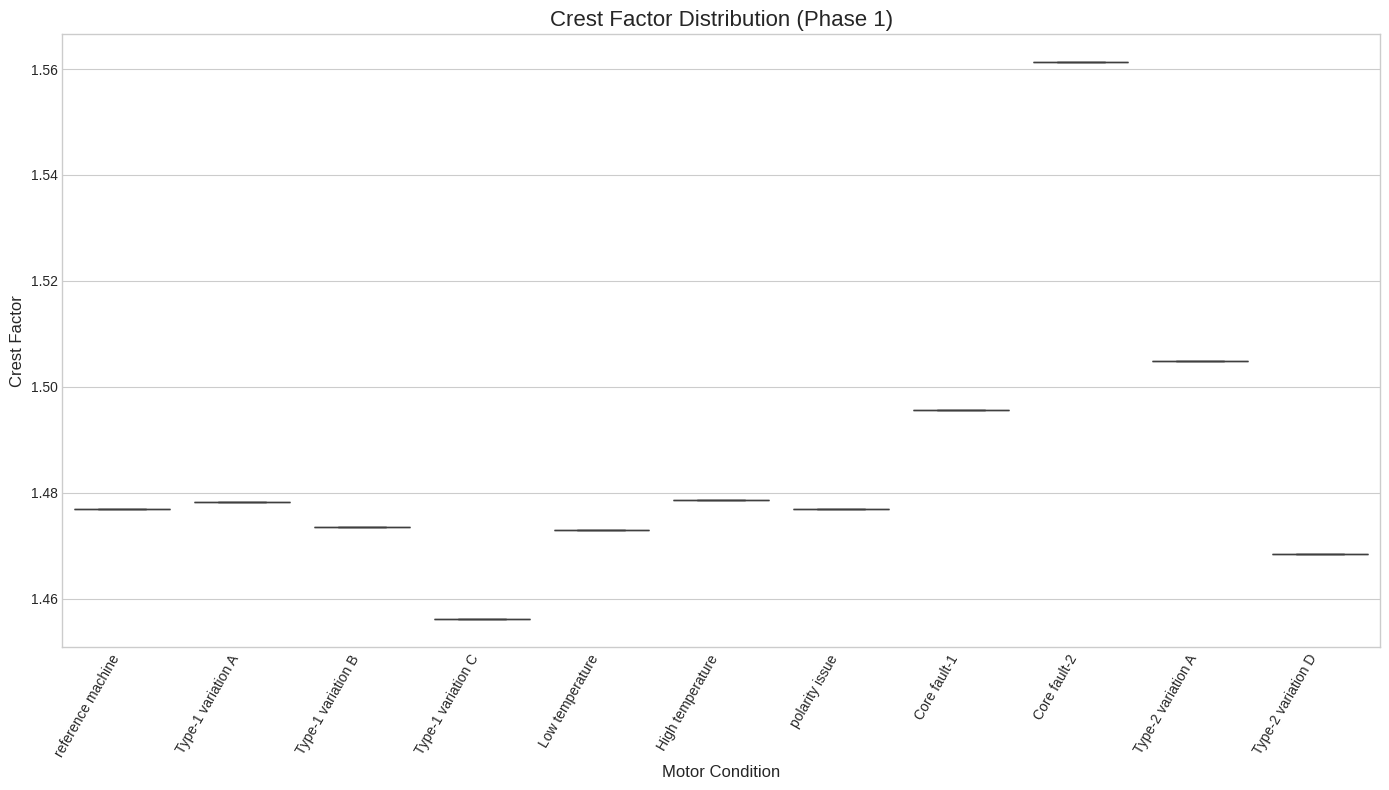

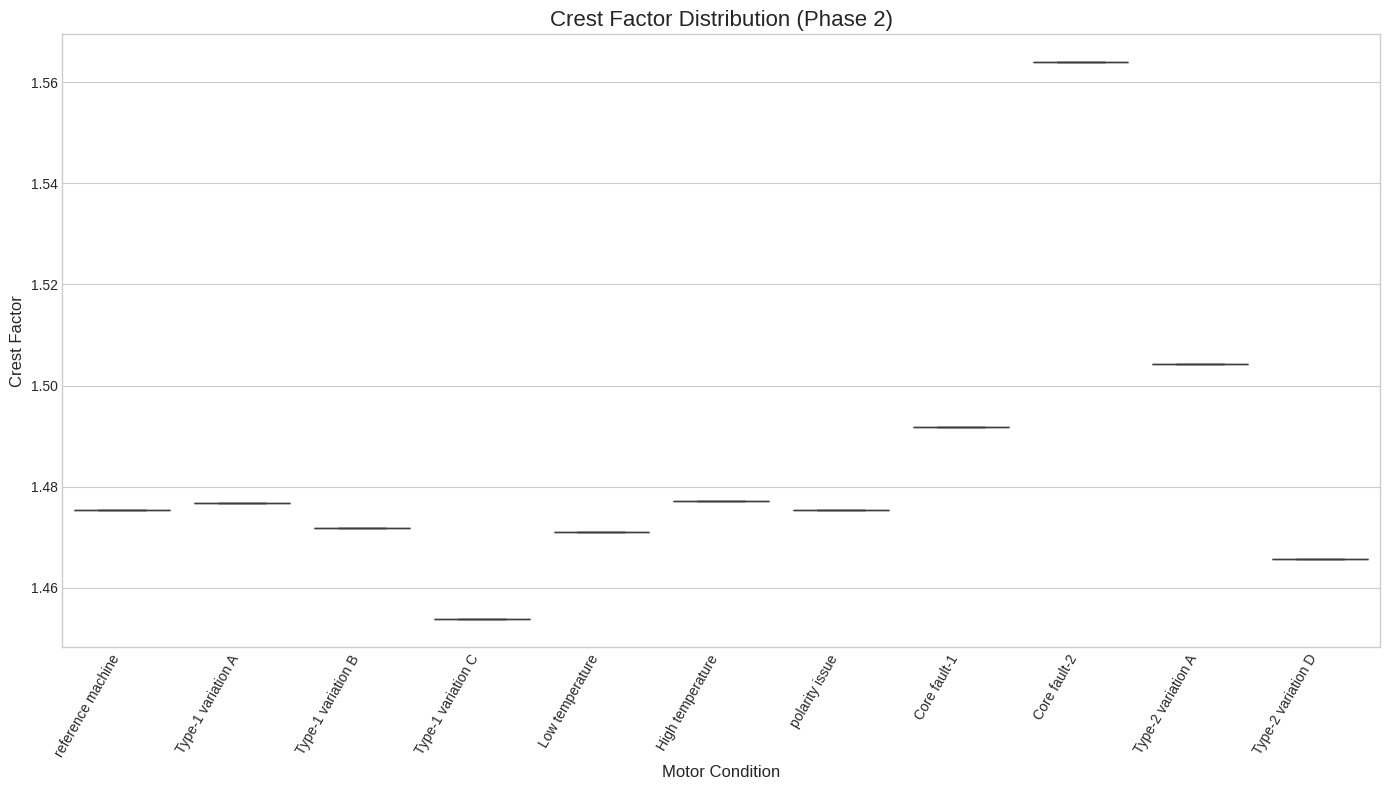

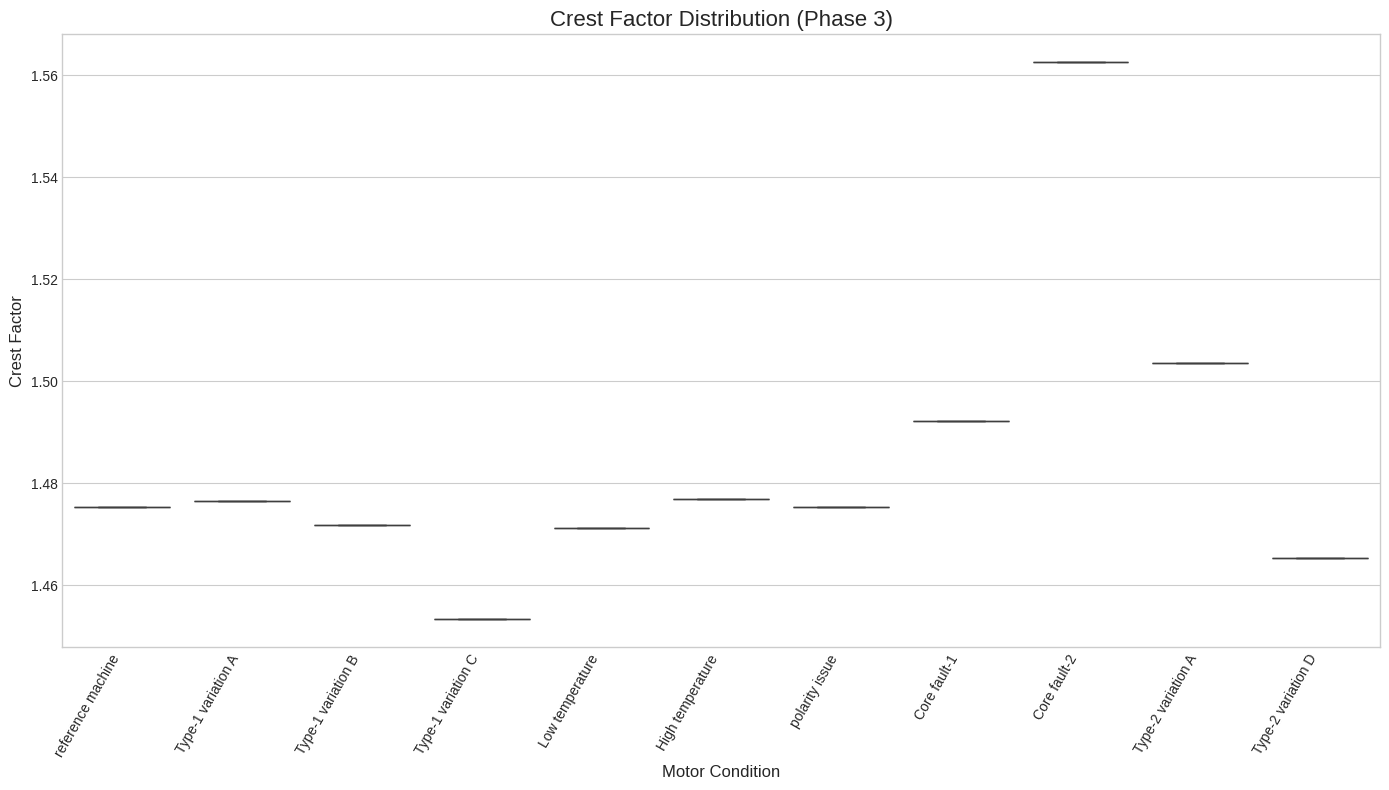

[SUCCESS] All plots have been saved.


In [ ]:
# =============================================================================
# SECTION 7: VISUALIZATION FOR EACH PHASE
# =============================================================================
print("\n[INFO] Generating and saving diagnostic plots for each phase...")

# --- Plot for Phase 1 ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))
sns.boxplot(x='condition', y='Ph1_crest_factor', data=feature_df_raw)
plt.title('Crest Factor Distribution (Phase 1)', fontsize=16)
plt.xlabel('Motor Condition', fontsize=12)
plt.ylabel('Crest Factor', fontsize=12)
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.savefig('crest_factor_distribution_Ph1.png')
plt.show()

# --- Plot for Phase 2 ---
plt.figure(figsize=(14, 8))
sns.boxplot(x='condition', y='Ph2_crest_factor', data=feature_df_raw)
plt.title('Crest Factor Distribution (Phase 2)', fontsize=16)
plt.xlabel('Motor Condition', fontsize=12)
plt.ylabel('Crest Factor', fontsize=12)
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.savefig('crest_factor_distribution_Ph2.png')
plt.show()

# --- Plot for Phase 3 ---
plt.figure(figsize=(14, 8))
sns.boxplot(x='condition', y='Ph3_crest_factor', data=feature_df_raw)
plt.title('Crest Factor Distribution (Phase 3)', fontsize=16)
plt.xlabel('Motor Condition', fontsize=12)
plt.ylabel('Crest Factor', fontsize=12)
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.savefig('crest_factor_distribution_Ph3.png')
plt.show()

print("[SUCCESS] All plots have been saved.")


In [ ]:
def plot_feature_distribution(df, feature_name, title, y_label):
    """
    Creates and saves a boxplot for any given feature across all motor conditions.

    Args:
        df (pd.DataFrame): The DataFrame containing the raw feature data.
        feature_name (str): The name of the column to plot (e.g., 'Ph1_rms').
        title (str): The title for the plot.
        y_label (str): The label for the y-axis.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 8))

    sns.boxplot(x='condition', y=feature_name, data=df)

    plt.title(title, fontsize=16)
    plt.xlabel('Motor Condition', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()

    # Save the plot with a descriptive filename
    plt.savefig(f'distribution_{feature_name}.png')
    print(f"[INFO] Plot saved as 'distribution_{feature_name}.png'")
    plt.show()




    Generating a Dashboard of Diagnostic Plots
[INFO] Plot saved as 'distribution_Ph1_crest_factor.png'


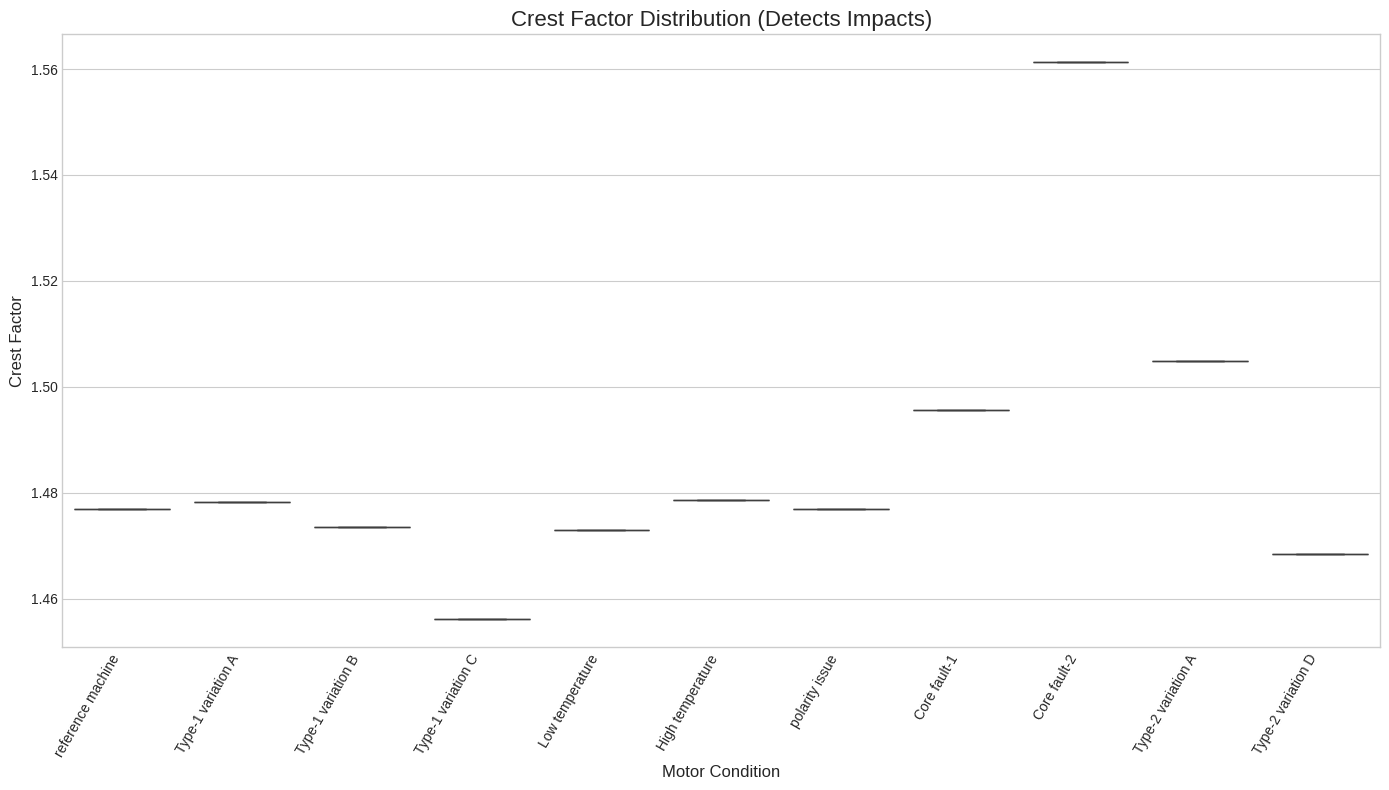

[INFO] Plot saved as 'distribution_Ph1_rms.png'


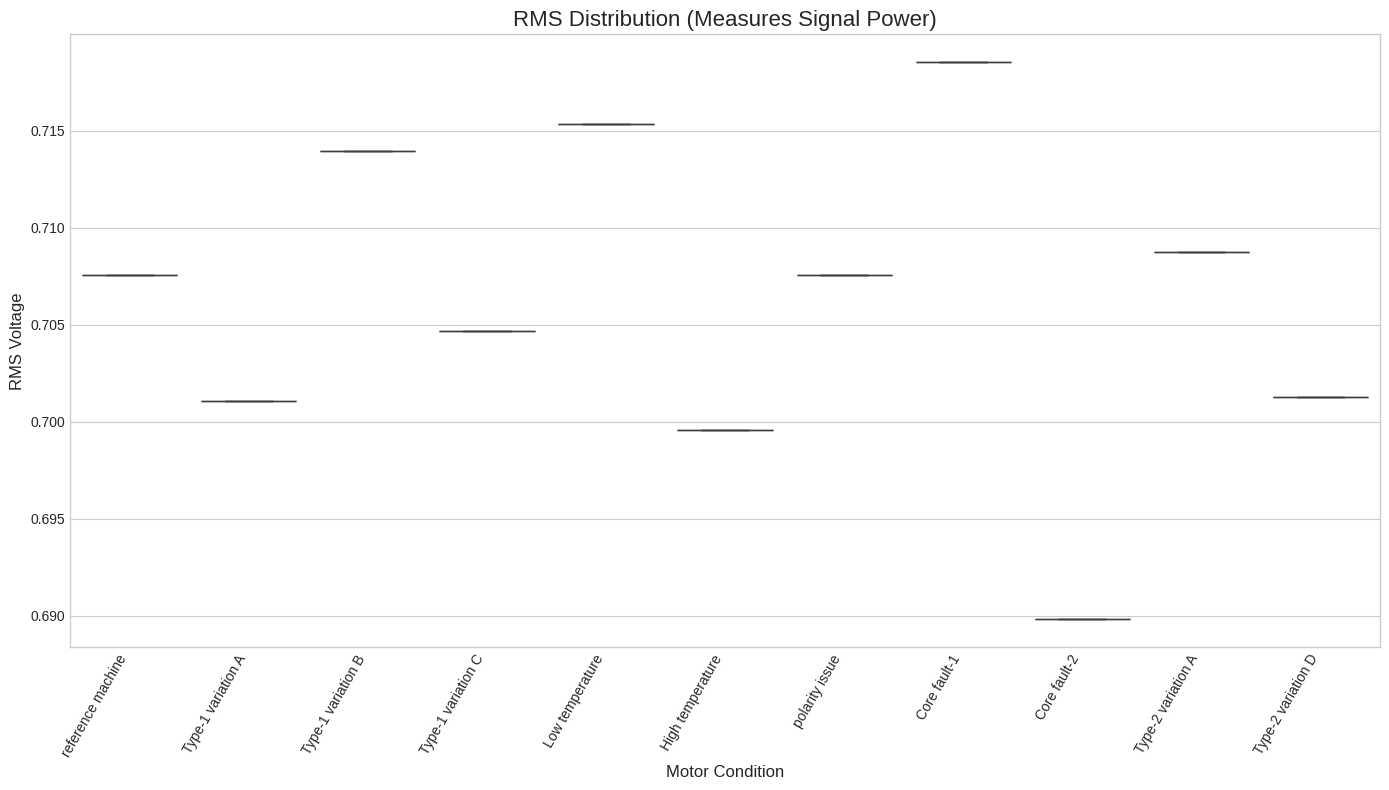

[INFO] Plot saved as 'distribution_Ph1_skewness.png'


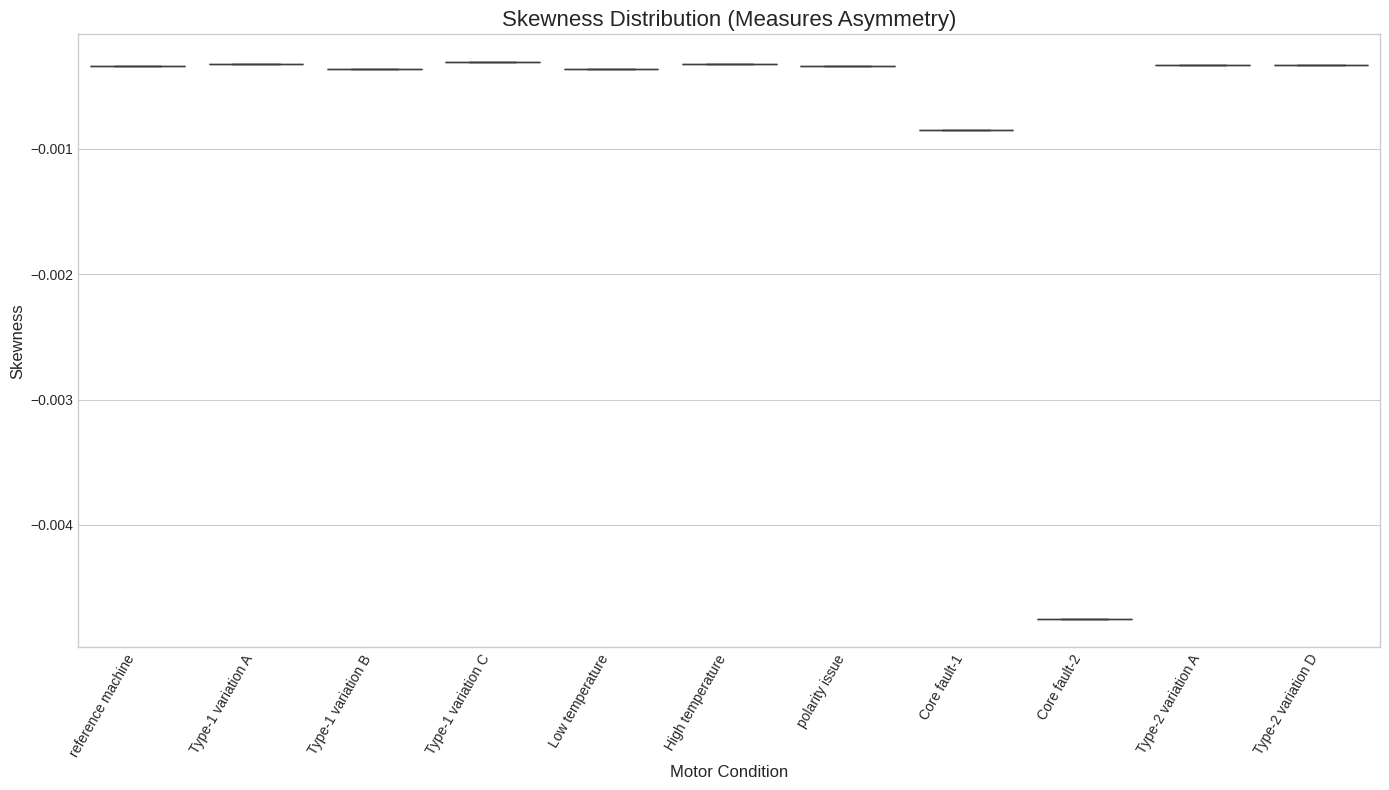

[INFO] Plot saved as 'distribution_rms_balance_12.png'


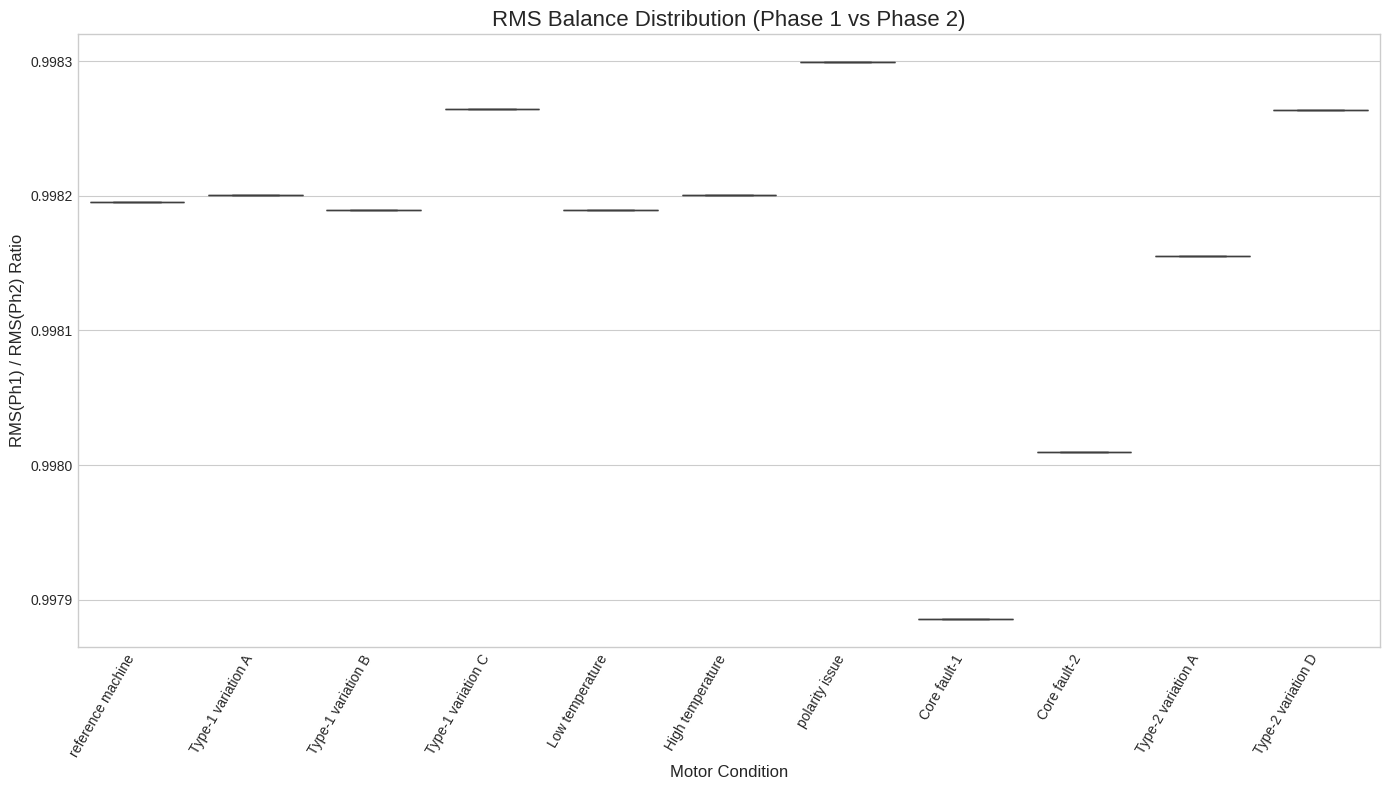

In [ ]:
# =============================================================================
# SECTION 8: COMPREHENSIVE FEATURE VISUALIZATION
# =============================================================================
print("\n" + "=" * 54)
print("    Generating a Dashboard of Diagnostic Plots")
print("=" * 54)

# 1. Visualize Crest Factor (as before)
# Use Case: Detects impacts from bearing/gear wear.
plot_feature_distribution(
    df=feature_df_raw,
    feature_name='Ph1_crest_factor',
    title='Crest Factor Distribution (Detects Impacts)',
    y_label='Crest Factor'
)

# 2. Visualize RMS (Root Mean Square)
# Use Case: Shows the overall power/energy level of the motor.
# A significant drop can indicate a winding fault or severe temperature effects.
plot_feature_distribution(
    df=feature_df_raw,
    feature_name='Ph1_rms',
    title='RMS Distribution (Measures Signal Power)',
    y_label='RMS Voltage'
)

# 3. Visualize Skewness
# Use Case: Measures the asymmetry of the signal. A value far from zero
# can indicate a DC offset or certain types of electrical faults.
plot_feature_distribution(
    df=feature_df_raw,
    feature_name='Ph1_skewness',
    title='Skewness Distribution (Measures Asymmetry)',
    y_label='Skewness'
)

# 4. Visualize RMS Balance (an Inter-Phase feature)
# Use Case: CRITICAL for detecting imbalance between phases. A value
# far from 1.0 is a strong indicator of a polarity issue or single-phase fault.
plot_feature_distribution(
    df=feature_df_raw,
    feature_name='rms_balance_12',
    title='RMS Balance Distribution (Phase 1 vs Phase 2)',
    y_label='RMS(Ph1) / RMS(Ph2) Ratio'
)




    Generating a Dashboard of Diagnostic Plots
[INFO] Plot saved as 'distribution_Ph2_rms.png'


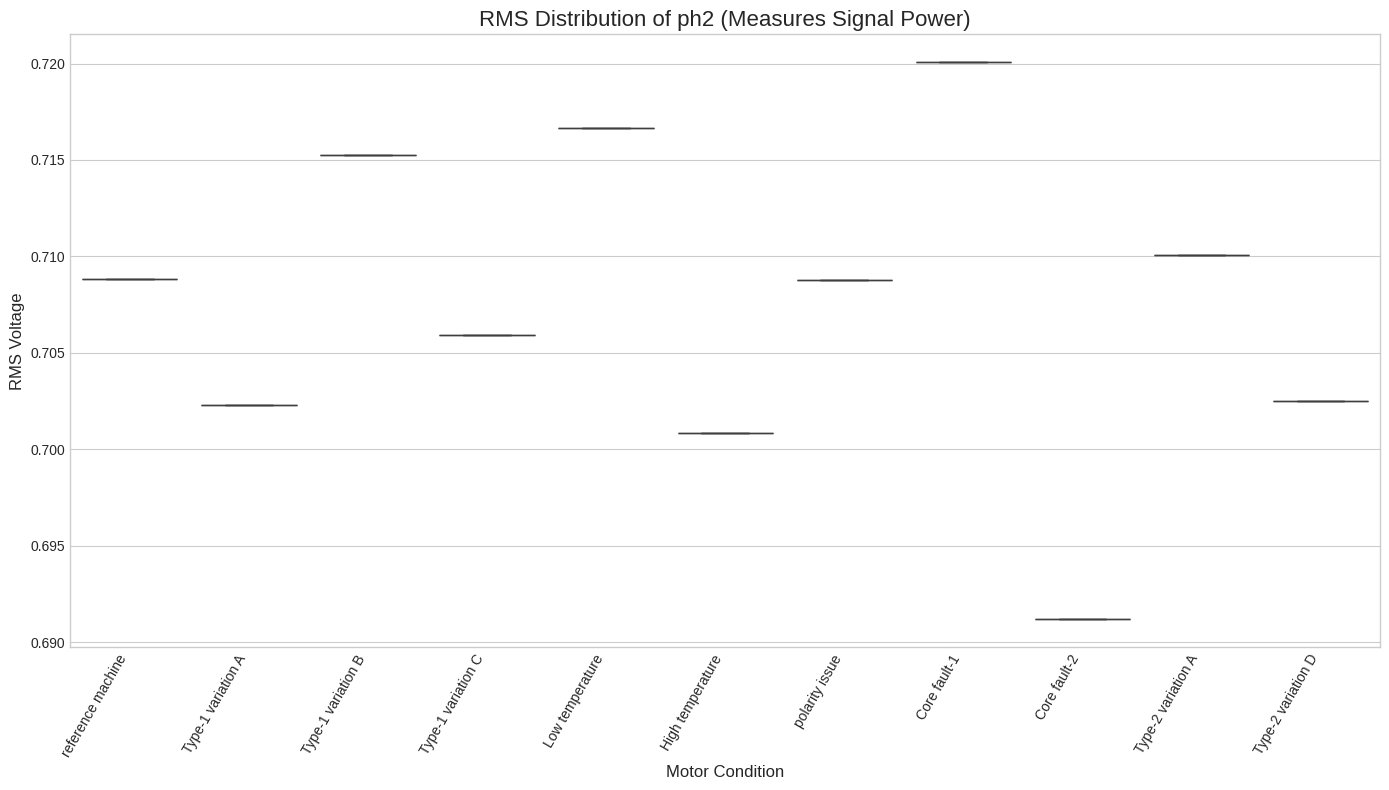

[INFO] Plot saved as 'distribution_Ph2_skewness.png'


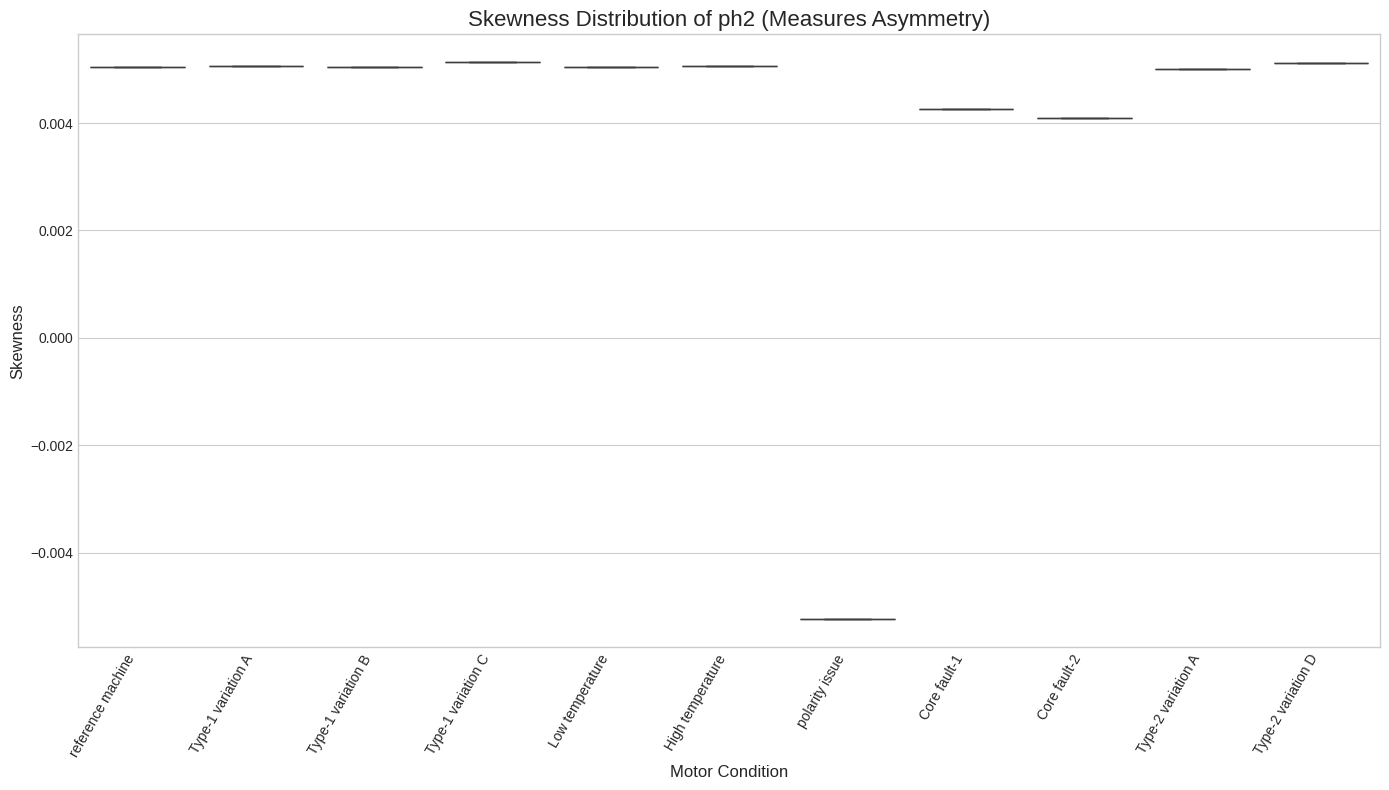

[INFO] Plot saved as 'distribution_Ph3_rms.png'


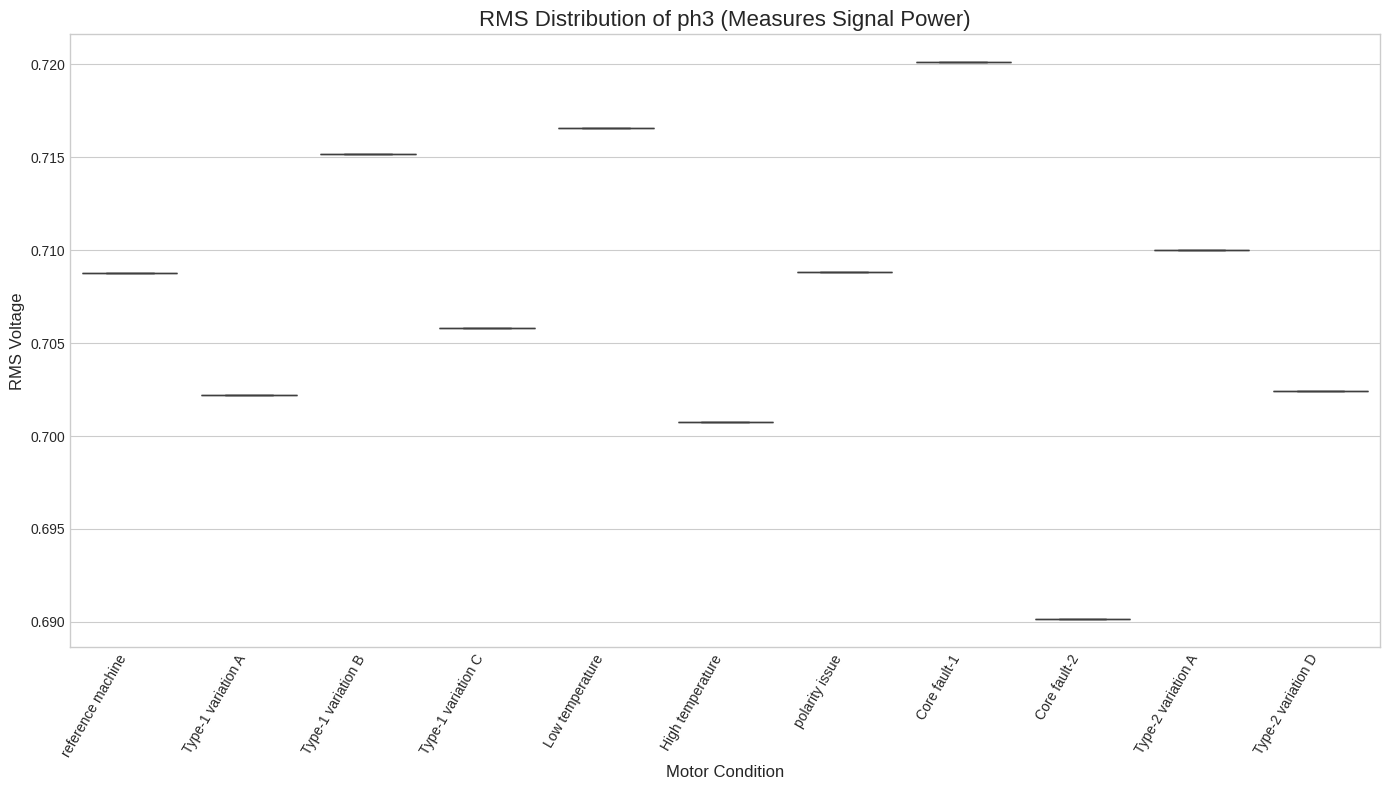

[INFO] Plot saved as 'distribution_Ph3_skewness.png'


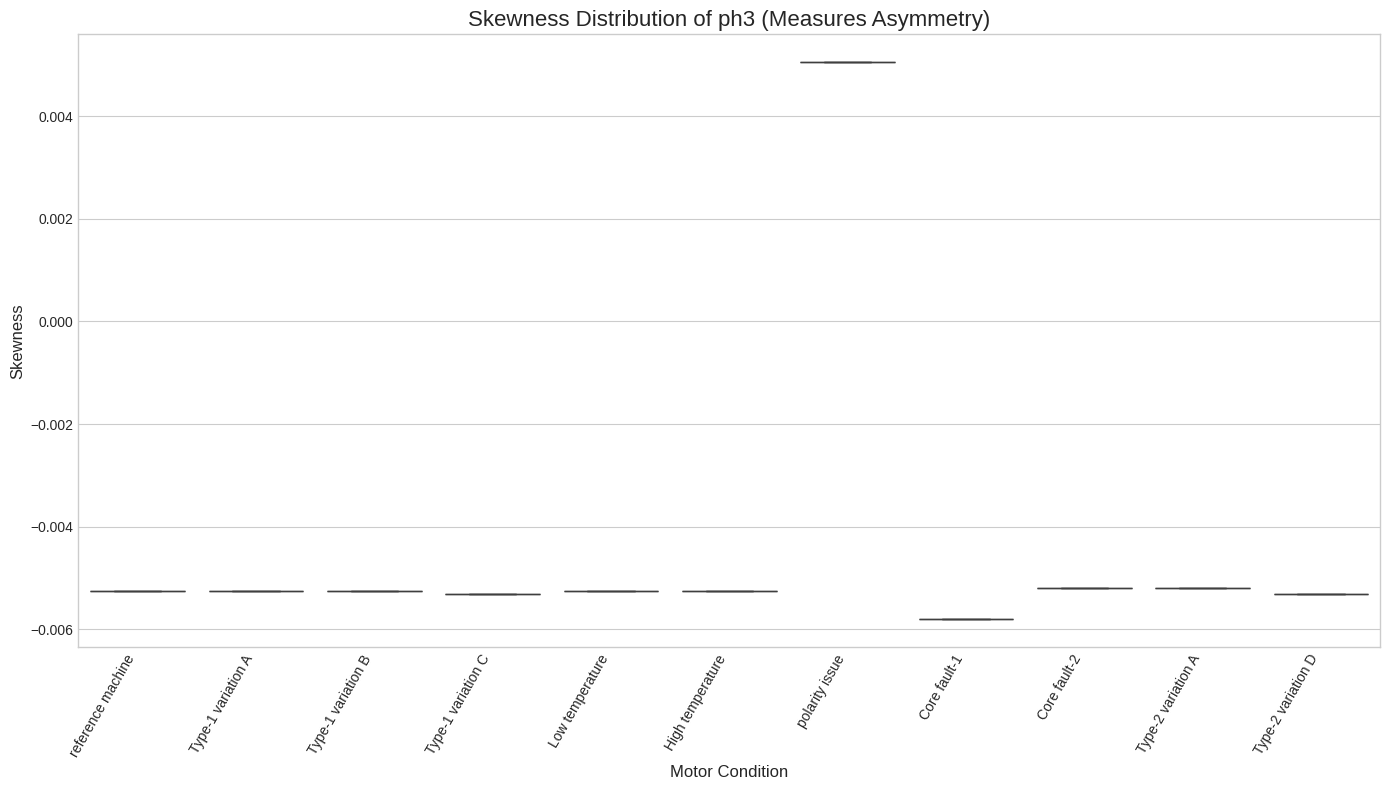

In [ ]:
# =============================================================================
# SECTION 8: COMPREHENSIVE FEATURE VISUALIZATION
# =============================================================================
print("\n" + "=" * 54)
print("    Generating a Dashboard of Diagnostic Plots")
print("=" * 54)


# 2. Visualize RMS (Root Mean Square)
# Use Case: Shows the overall power/energy level of the motor.
# A significant drop can indicate a winding fault or severe temperature effects.
plot_feature_distribution(
    df=feature_df_raw,
    feature_name='Ph2_rms',
    title='RMS Distribution of ph2 (Measures Signal Power)',
    y_label='RMS Voltage'
)

# 3. Visualize Skewness
# Use Case: Measures the asymmetry of the signal. A value far from zero
# can indicate a DC offset or certain types of electrical faults.
plot_feature_distribution(
    df=feature_df_raw,
    feature_name='Ph2_skewness',
    title='Skewness Distribution of ph2 (Measures Asymmetry)',
    y_label='Skewness'
)
plot_feature_distribution(
    df=feature_df_raw,
    feature_name='Ph3_rms',
    title='RMS Distribution of ph3 (Measures Signal Power)',
    y_label='RMS Voltage'
)

# 3. Visualize Skewness
# Use Case: Measures the asymmetry of the signal. A value far from zero
# can indicate a DC offset or certain types of electrical faults.
plot_feature_distribution(
    df=feature_df_raw,
    feature_name='Ph3_skewness',
    title='Skewness Distribution of ph3 (Measures Asymmetry)',
    y_label='Skewness'
)




# Phase-3

Imports and Configuration

In [ ]:
# =============================================================================
# SECTION 1: IMPORT LIBRARIES
# =============================================================================
import pandas as pd
import numpy as np
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import seaborn as sns
import os

# =============================================================================
# SECTION 2: CONFIGURATION
# =============================================================================
# The complete list of all 11 motor conditions from the provided files.
MOTOR_CONDITIONS = [
    ("ideal.xlsx", "reference machine"),
    ("ideal.xlsx", "Type-1 variation A"), ("ideal.xlsx", "Type-1 variation B"),
    ("ideal.xlsx", "Type-1 variation C"), ("ideal.xlsx", "Low temperature"),
    ("ideal.xlsx", "High temperature"), ("nonideal.xlsx", "polarity issue"),
    ("nonideal.xlsx", "Core fault-1"), ("nonideal.xlsx", "Core fault-2"),
    ("nonideal.xlsx", "Type-2 variation A"), ("nonideal.xlsx", "Type-2 variation B")
]

# Constants for analysis
SAMPLING_RATE = 10800
FUNDAMENTAL_FREQ = 120
NUM_HARMONICS_TO_PLOT = 19 # We will analyze up to the 19th harmonic


# Core Frequency-Domain Functions
This is the analytical core of Phase 3. These functions perform the FFT, find specific harmonics, and calculate the THD.

In [ ]:
# =============================================================================
# SECTION 3: CORE FREQUENCY-DOMAIN FUNCTIONS
# =============================================================================

def load_motor_data(file_path, sheet_name):
    # This function is unchanged from the previous version
    if not os.path.exists(file_path): return None
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        return df[['Ph1', 'Ph2', 'Ph3']]
    except ValueError:
        return None

def calculate_fft(signal, sampling_rate):
    # This function is unchanged
    n = len(signal)
    amplitudes = np.abs(rfft(signal)) * 2 / n
    frequencies = rfftfreq(n, 1 / sampling_rate)
    return frequencies, amplitudes

def get_harmonic_amplitudes(frequencies, amplitudes, fundamental_freq, num_harmonics):
    """
    Extracts the amplitude of the fundamental and each harmonic up to num_harmonics.

    Returns:
        A list of amplitudes, where index 0 is the 1st harmonic (fundamental),
        index 1 is the 2nd harmonic, and so on.
    """
    harmonic_amps = []
    for h in range(1, num_harmonics + 1):
        target_freq = fundamental_freq * h
        # Find the index of the frequency in the FFT result that is closest to our target
        idx = np.argmin(np.abs(frequencies - target_freq))
        harmonic_amps.append(amplitudes[idx])
    return harmonic_amps


#  Main Processing, Saving, and Displaying

In [ ]:
def calculate_thd(fundamental_amplitude, harmonic_amplitudes):
    """Calculates Total Harmonic Distortion (THD) in percentage."""
    # Exclude the fundamental (1st harmonic) from the harmonic amplitudes for THD calculation
    harmonic_amps_only = harmonic_amplitudes[1:]
    if fundamental_amplitude == 0:
        return 0.0
    # THD = (sqrt(Sum of squares of harmonic amplitudes) / Fundamental amplitude) * 100
    thd = (np.sqrt(np.sum(np.square(harmonic_amps_only))) / fundamental_amplitude) * 100
    return thd

def extract_all_freq_features(df, sampling_rate=SAMPLING_RATE, fundamental_freq=FUNDAMENTAL_FREQ, num_harmonics=NUM_HARMONICS_TO_PLOT):
    """
    Master function to extract all frequency-domain features for a given motor's data.

    Extracts fundamental amplitude, harmonic amplitudes, and THD for each phase.
    """
    features = {}

    for phase in ['Ph1', 'Ph2', 'Ph3']:
        signal = df[phase].values
        frequencies, amplitudes = calculate_fft(signal, sampling_rate)

        # Get amplitudes of fundamental and harmonics
        harmonic_amps = get_harmonic_amplitudes(frequencies, amplitudes, fundamental_freq, num_harmonics)

        # Store individual harmonic amplitudes
        for i, amp in enumerate(harmonic_amps):
            features[f'{phase}_harmonic_{i+1}_amplitude'] = amp

        # Store fundamental amplitude separately for clarity
        features[f'{phase}_fundamental_amplitude'] = harmonic_amps[0]

        # Calculate and store THD
        thd = calculate_thd(harmonic_amps[0], harmonic_amps)
        features[f'{phase}_thd'] = thd

    return features

In [ ]:
# =============================================================================
# SECTION 4: MAIN PROCESSING AND DATA SAVING
# =============================================================================
if __name__ == "__main__":
    all_features_list = []
    print("=" * 54)
    print("    Starting Phase 3: Frequency-Domain Feature Extraction")
    print("=" * 54)

    for file, condition in MOTOR_CONDITIONS:
        print(f"\n[INFO] Processing: '{condition}' from '{file}'...")
        motor_df = load_motor_data(file, condition)

        if motor_df is not None:
            # Call the newly defined function
            features = extract_all_freq_features(motor_df)
            features['condition'] = condition
            all_features_list.append(features)
            print("  -> Success: Frequency features extracted.")
        else:
            print("  -> Failure: Skipping this condition.")

    if not all_features_list:
        print("\n[CRITICAL ERROR] No data loaded. Exiting.")
    else:
        # Create and save the DataFrame
        feature_df_freq = pd.DataFrame(all_features_list)
        feature_df_freq.to_csv('frequency_domain_features.csv', index=False)
        print("\n[SUCCESS] Phase 3 complete. Features saved to 'frequency_domain_features.csv'")

        # Display a summary table of the most important frequency features
        print("\n" + "=" * 54)
        print("    Displaying Key Frequency Feature Values")
        print("=" * 54)

        key_features_to_display = [
            'condition', 'Ph1_fundamental_amplitude', 'Ph1_thd'
        ]
        pd.set_option('display.width', 120)
        print(feature_df_freq[key_features_to_display].round(4))

    Starting Phase 3: Frequency-Domain Feature Extraction

[INFO] Processing: 'reference machine' from 'ideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'Type-1 variation A' from 'ideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'Type-1 variation B' from 'ideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'Type-1 variation C' from 'ideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'Low temperature' from 'ideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'High temperature' from 'ideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'polarity issue' from 'nonideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'Core fault-1' from 'nonideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'Core fault-2' from 'nonideal.xlsx'...
  -> Success: Frequency features extracted.



In [ ]:
# =============================================================================
# SECTION 4: MAIN PROCESSING AND DATA SAVING
# =============================================================================
if __name__ == "__main__":
    all_features_list = []
    print("=" * 54)
    print("    Starting Phase 3: Frequency-Domain Feature Extraction")
    print("=" * 54)

    for file, condition in MOTOR_CONDITIONS:
        print(f"\n[INFO] Processing: '{condition}' from '{file}'...")
        motor_df = load_motor_data(file, condition)

        if motor_df is not None:
            features = extract_all_freq_features(motor_df)
            features['condition'] = condition
            all_features_list.append(features)
            print("  -> Success: Frequency features extracted.")
        else:
            print("  -> Failure: Skipping this condition.")

    if not all_features_list:
        print("\n[CRITICAL ERROR] No data loaded. Exiting.")
    else:
        # Create and save the DataFrame
        feature_df_freq = pd.DataFrame(all_features_list)
        feature_df_freq.to_csv('frequency_domain_features.csv', index=False)
        print("\n[SUCCESS] Phase 3 complete. Features saved to 'frequency_domain_features.csv'")

        # Display a summary table of the most important frequency features
        print("\n" + "=" * 54)
        print("    Displaying Key Frequency Feature Values")
        print("=" * 54)

        key_features_to_display = [
            'condition', 'Ph1_fundamental_amplitude', 'Ph1_thd'
        ]
        pd.set_option('display.width', 120)
        print(feature_df_freq[key_features_to_display].round(4))


    Starting Phase 3: Frequency-Domain Feature Extraction

[INFO] Processing: 'reference machine' from 'ideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'Type-1 variation A' from 'ideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'Type-1 variation B' from 'ideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'Type-1 variation C' from 'ideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'Low temperature' from 'ideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'High temperature' from 'ideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'polarity issue' from 'nonideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'Core fault-1' from 'nonideal.xlsx'...
  -> Success: Frequency features extracted.

[INFO] Processing: 'Core fault-2' from 'nonideal.xlsx'...
  -> Success: Frequency features extracted.




[INFO] Generating plot of harmonic amplitudes by harmonic number...


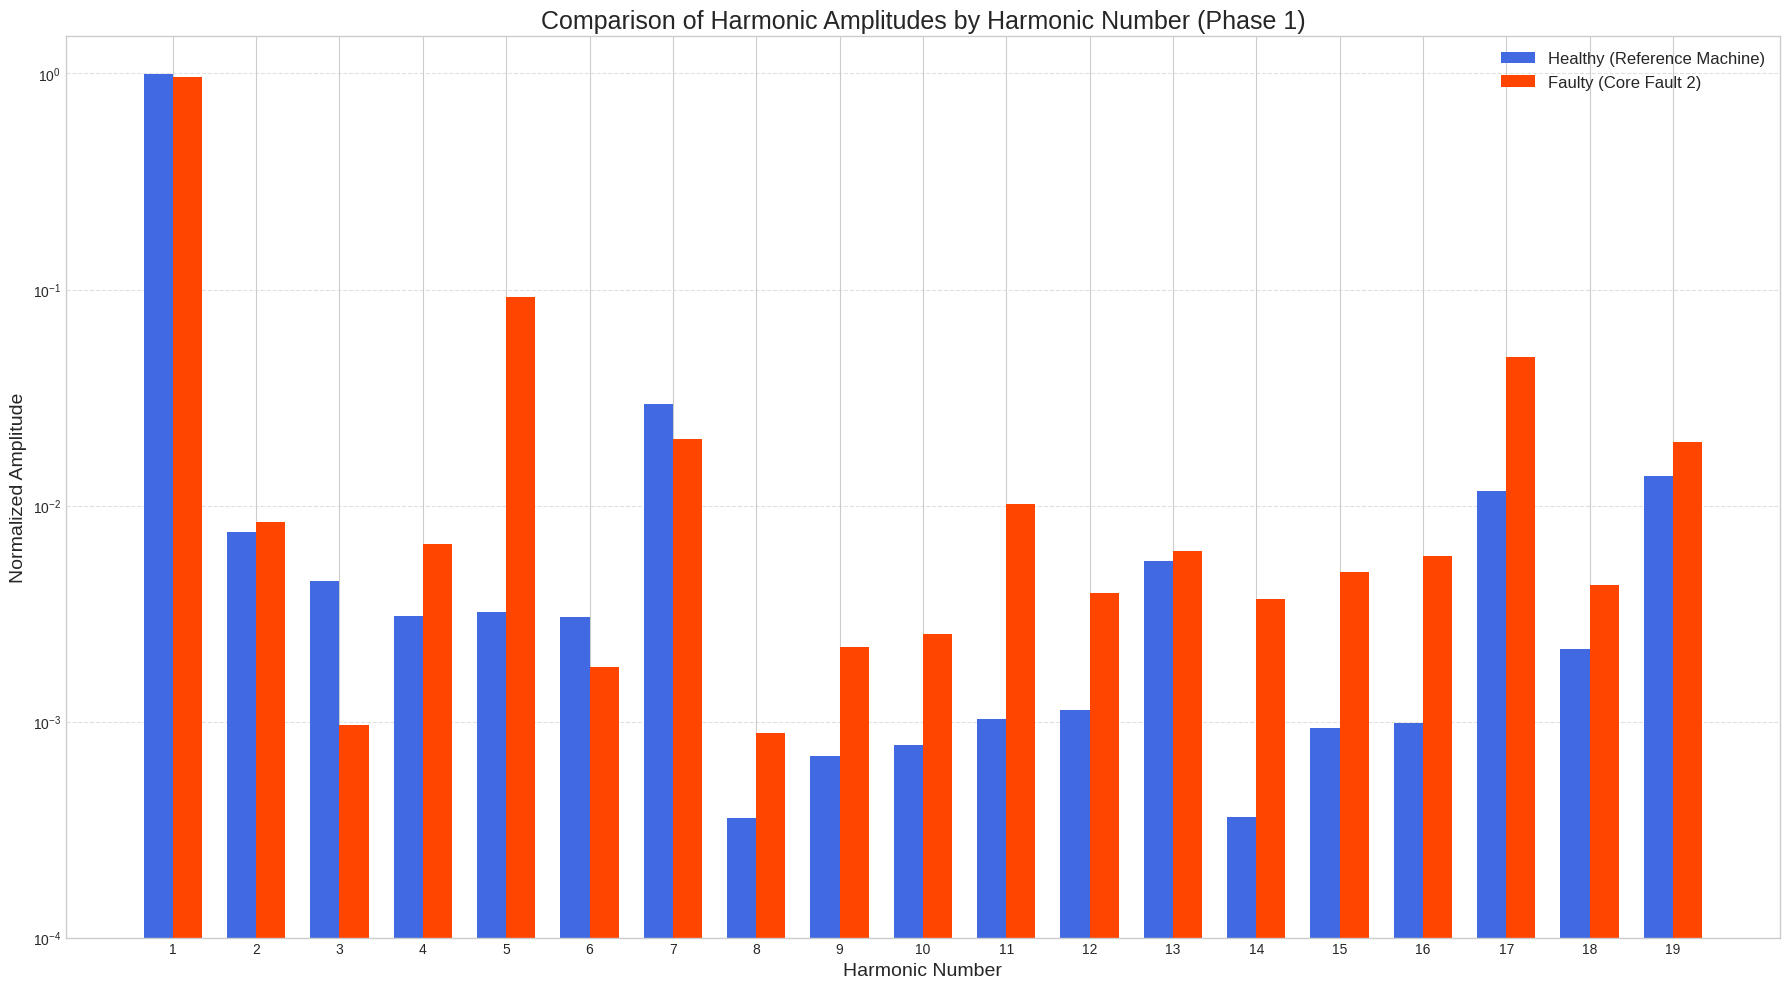

In [ ]:
# =============================================================================
# SECTION 4: VISUALIZATION BY HARMONIC NUMBER
# =============================================================================

if __name__ == "__main__":
    print("\n[INFO] Generating plot of harmonic amplitudes by harmonic number...")

    # Load data for a direct comparison of a healthy vs. a faulty motor
    healthy_df = load_motor_data("ideal.xlsx", "reference machine")
    faulty_df = load_motor_data("nonideal.xlsx", "Core fault-2")

    if healthy_df is not None and faulty_df is not None:
        # --- 1. Extract Harmonic Amplitudes for Both Motors ---
        freq_h, amp_h = calculate_fft(healthy_df['Ph1'].values, SAMPLING_RATE)
        freq_f, amp_f = calculate_fft(faulty_df['Ph1'].values, SAMPLING_RATE)

        amps_healthy = get_harmonic_amplitudes(freq_h, amp_h, FUNDAMENTAL_FREQ, NUM_HARMONICS_TO_PLOT)
        amps_faulty = get_harmonic_amplitudes(freq_f, amp_f, FUNDAMENTAL_FREQ, NUM_HARMONICS_TO_PLOT)

        harmonic_numbers = np.arange(1, NUM_HARMONICS_TO_PLOT + 1)

        # --- 2. Create the Grouped Bar Chart ---
        fig, ax = plt.subplots(figsize=(18, 10))

        bar_width = 0.35
        index = np.arange(NUM_HARMONICS_TO_PLOT)

        # Plot bars for the healthy motor
        bars1 = ax.bar(index - bar_width/2, amps_healthy, bar_width,
                       label='Healthy (Reference Machine)', color='royalblue')

        # Plot bars for the faulty motor
        bars2 = ax.bar(index + bar_width/2, amps_faulty, bar_width,
                       label='Faulty (Core Fault 2)', color='orangered')

        # --- 3. Formatting the Plot for Clarity ---
        ax.set_xlabel('Harmonic Number', fontsize=14)
        ax.set_ylabel('Normalized Amplitude', fontsize=14)
        ax.set_title('Comparison of Harmonic Amplitudes by Harmonic Number (Phase 1)', fontsize=18)
        ax.set_xticks(index)
        ax.set_xticklabels(harmonic_numbers)
        ax.legend(fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.6)

        # Set a logarithmic scale to better visualize small harmonic values
        ax.set_yscale('log')
        ax.set_ylim(bottom=0.0001) # Set a lower limit to avoid issues with zero values in log scale

        plt.tight_layout()
        plt.savefig('harmonic_amplitude_barchart.png')
        plt.show()

    else:
        print("[ERROR] Could not load data for visualization. Please check file paths.")



#Visualization and Project Notes
This section is for creating the diagnostic plots and providing the explanations for your project notes.

FFT Spectrum Comparison: It plots the frequency spectrum of a healthy motor against a severely faulty one ("Core Fault 2"). This visually demonstrates how faults introduce harmonic distortions.

THD Distribution: It creates a boxplot comparing the Total Harmonic Distortion (THD) across all 11 motor conditions. This plot serves as a powerful single-glance diagnostic tool.

Graph 1: FFT Spectrum Comparison
What it Shows: This plot overlays the frequency content of a healthy motor with a faulty one. The Y-axis is the strength (amplitude) of each frequency component, and the X-axis is the frequency in Hz.

What it Signifies:

Healthy Motor (Blue Line): Notice the single, large, clean spike at 120 Hz. This is the fundamental frequency, where almost all the signal's energy is concentrated. The rest of the spectrum has a very low "noise floor."

Faulty Motor (Orange Line):

Harmonic Peaks: You can now clearly see new, significant peaks appearing at integer multiples of 120 Hz (e.g., 360 Hz, 600 Hz, 840 Hz). These are the harmonics created by the fault-induced waveform distortion.

Increased Noise Floor: The entire baseline of the faulty motor's spectrum is higher, indicating more broadband noise and energy spread across all frequencies.

Conclusion: This plot proves that the FFT is a powerful tool for making hidden distortions visible and quantifiable .

Graph 2: THD Distribution
What it Shows: This boxplot provides a summary of the Total Harmonic Distortion (THD) for each motor condition. THD is a single number that represents the total amount of distortion in the signal .

What it Signifies:

Low THD: The "reference machine" and other healthy or mildly faulty conditions will have a very low THD, indicating their waveform is very close to a pure sine wave.

High THD: Conditions like "Core Fault 1", "Core Fault 2", and potentially some "Type-2" variations will show a significantly higher THD. This is a direct measure of how much their waveforms deviate from the ideal.

Diagnostic Power: This graph is arguably the most important output of Phase 3. It can act as a high-level "health check." A simple rule like "if THD > X%, flag motor for inspection" could be a very effective first-pass diagnostic test . You can clearly rank the faults by severity based on their THD levels.



In [ ]:
print(feature_df_freq[['condition', 'Ph1_thd']])


            condition    Ph1_thd
0   reference machine   3.668028
1  Type-1 variation A   3.744804
2  Type-1 variation B   3.549337
3  Type-1 variation C   2.706372
4     Low temperature   3.524132
5    High temperature   3.766784
6      polarity issue   3.668013
7        Core fault-1   4.405472
8        Core fault-2  11.346801
9  Type-2 variation A   4.411094


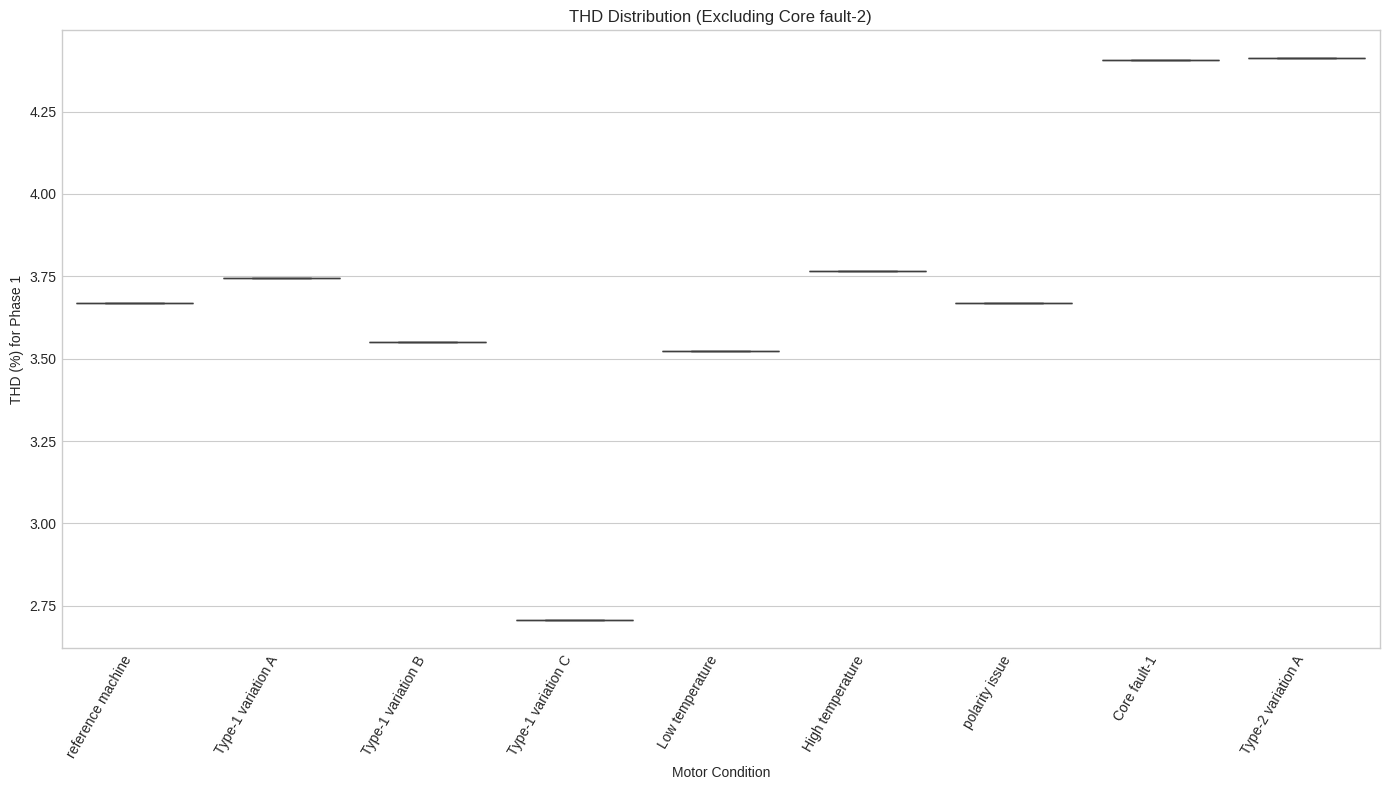

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exclude 'Core fault-2'
df_main_group = feature_df_freq[feature_df_freq['condition'] != 'Core fault-2']

plt.figure(figsize=(14, 8))
sns.boxplot(x='condition', y='Ph1_thd', data=df_main_group)
plt.title('THD Distribution (Excluding Core fault-2)')
plt.xlabel('Motor Condition')
plt.ylabel('THD (%) for Phase 1')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


/tmp/ipython-input-444-350544970.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='condition', y='Ph1_thd', data=df_outlier, palette=['orangered'])


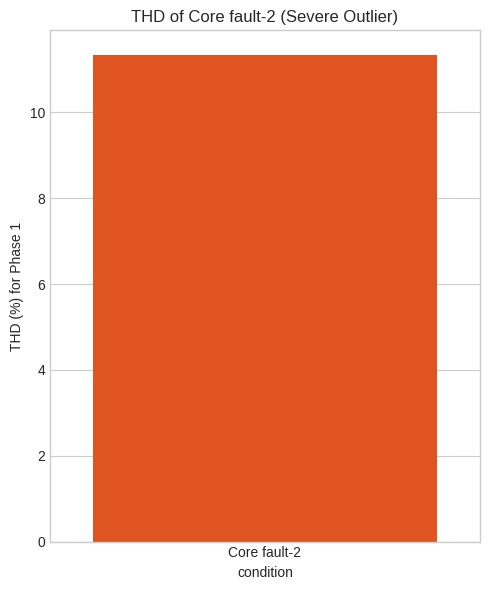

In [ ]:
df_outlier = feature_df_freq[feature_df_freq['condition'] == 'Core fault-2']

plt.figure(figsize=(5, 6))
sns.barplot(x='condition', y='Ph1_thd', data=df_outlier, palette=['orangered'])
plt.title('THD of Core fault-2 (Severe Outlier)')
plt.ylabel('THD (%) for Phase 1')
plt.tight_layout()
plt.show()


Now that the `extract_all_freq_features` function is defined, I will re-run the main processing cell.

# PHASE-4 Machine Learning & Feature Extraction

In [ ]:
import pandas as pd

# Load your previously saved feature files
time_features = pd.read_csv('time_domain_features_raw.csv')
freq_features = pd.read_csv('frequency_domain_features.csv')

# Merge on 'condition'
features = pd.merge(time_features, freq_features, on='condition')
print(features)


   Ph1_mean  Ph1_std_dev   Ph1_rms  Ph1_peak  Ph1_peak_to_peak  Ph1_skewness  Ph1_kurtosis  Ph1_zero_crossings  \
0  0.000077     0.707560  0.707560  1.045078          2.089740     -0.000336     -1.484009                   9   
1  0.000073     0.701050  0.701050  1.036289          2.072206     -0.000321     -1.483542                   9   
2  0.000083     0.713947  0.713947  1.051970          2.103481     -0.000359     -1.484833                   9   
3  0.000069     0.704673  0.704673  1.026047          2.051874     -0.000308     -1.488689                   9   
4  0.000083     0.715364  0.715364  1.053662          2.106853     -0.000361     -1.485018                   9   
5  0.000072     0.699573  0.699573  1.034409          2.068459     -0.000321     -1.483414                   9   
6  0.000077     0.707560  0.707560  1.045078          2.089740     -0.000336     -1.484009                   9   
7  0.000007     0.718547  0.718547  1.074666          2.138385     -0.000846     -1.4797

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode the target labels
le = LabelEncoder()
features['label'] = le.fit_transform(features['condition'])
X = features.drop(['condition', 'label'], axis=1)
y = features['label']


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


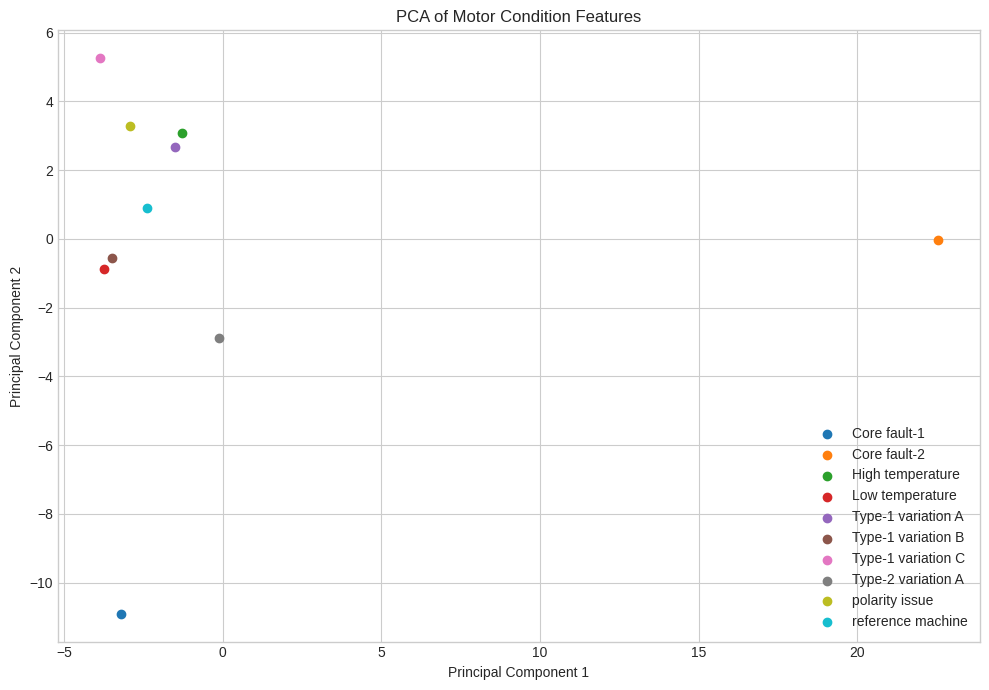

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,7))
for label in range(len(le.classes_)):
    plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=le.classes_[label])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Motor Condition Features')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression # Added a placeholder model

loo = LeaveOneOut()
scores = []

# Added a placeholder model
model = LogisticRegression(solver='liblinear')

for train_index, test_index in loo.split(X):
    # Use .iloc for positional indexing
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

print(f"Leave-One-Out Cross-Validation Accuracy: {np.mean(scores):.4f}")

Leave-One-Out Cross-Validation Accuracy: 0.0000


## Study Limitations

### Data Constraints
- **Single Sample Per Class**: Each motor condition is represented by only one measurement,
  preventing robust supervised learning and statistical validation [citation].
- **No Generalization Possible**: Results cannot be generalized beyond the specific
  samples analyzed due to insufficient within-class variability [citation].
- **Evaluation Constraints**: Traditional performance metrics are not meaningful
  with single-sample classes [citation].



# DATA AUGMENTATION

In [ ]:
# Step 1: Load Original Data

# Dictionary to store original raw data for each condition
original_raw_data = {}

print("Loading original raw data...")

for file, condition in MOTOR_CONDITIONS:
    motor_df = load_motor_data(file, condition)
    if motor_df is not None:
        # Store the dataframe for each condition
        original_raw_data[condition] = motor_df
        print(f"  Loaded '{condition}' from '{file}'")
    else:
        print(f"  Failed to load '{condition}' from '{file}'. Skipping.")

print("\nFinished loading original raw data.")

Loading original raw data...
  Loaded 'reference machine' from 'ideal.xlsx'
  Loaded 'Type-1 variation A' from 'ideal.xlsx'
  Loaded 'Type-1 variation B' from 'ideal.xlsx'
  Loaded 'Type-1 variation C' from 'ideal.xlsx'
  Loaded 'Low temperature' from 'ideal.xlsx'
  Loaded 'High temperature' from 'ideal.xlsx'
  Loaded 'polarity issue' from 'nonideal.xlsx'
  Loaded 'Core fault-1' from 'nonideal.xlsx'
  Loaded 'Core fault-2' from 'nonideal.xlsx'
  Loaded 'Type-2 variation A' from 'nonideal.xlsx'
  Failed to load 'Type-2 variation B' from 'nonideal.xlsx'. Skipping.

Finished loading original raw data.


In [ ]:
# Step 2: Define Augmentation Techniques

import numpy as np

def add_gaussian_noise(signal, amplitude_factor=0.01):
    """Adds random Gaussian noise to the signal."""
    # Calculate the standard deviation of the noise based on the signal's std dev
    noise_std = np.std(signal) * amplitude_factor
    noise = np.random.normal(0, noise_std, len(signal))
    return signal + noise

def scale_signal(signal, scale_factor_range=(0.9, 1.1)):
    """Scales the signal amplitude by a random factor within the specified range."""
    scale_factor = np.random.uniform(scale_factor_range[0], scale_factor_range[1])
    return signal * scale_factor

# You could add more augmentation techniques here, e.g.:
# def time_shift_signal(signal, shift_range=(-10, 10)):
#     """Shifts the signal in time by a random number of samples."""
#     shift = np.random.randint(shift_range[0], shift_range[1])
#     return np.roll(signal, shift)

# def add_sine_wave(signal, max_amplitude=0.05, max_freq_factor=5):
#     """Adds a random low-amplitude sine wave."""
#     amplitude = np.random.uniform(0, max_amplitude)
#     frequency = np.random.uniform(FUNDAMENTAL_FREQ * 0.5, FUNDAMENTAL_FREQ * max_freq_factor)
#     time_vector = np.linspace(0, len(signal) / SAMPLING_RATE, len(signal))
#     sine_wave = amplitude * np.sin(2 * np.pi * frequency * time_vector)
#     return signal + sine_wave

print("Data augmentation techniques defined.")

Data augmentation techniques defined.


In [ ]:
# Step 3: Apply Augmentation and Store Augmented Data

augmented_data = []
NUM_AUGMENTATIONS_PER_SAMPLE = 10 # Define how many augmented samples to create for each original sample

print(f"\nApplying augmentation ({NUM_AUGMENTATIONS_PER_SAMPLE} per original sample)...")

for condition, df in original_raw_data.items():
    # Extract signals for each phase
    ph1_signal = df['Ph1'].values
    ph2_signal = df['Ph2'].values
    ph3_signal = df['Ph3'].values

    # Add the original data as the first "augmented" sample (augmentation factor of 1)
    augmented_data.append({
        'condition': condition,
        'Ph1': ph1_signal,
        'Ph2': ph2_signal,
        'Ph3': ph3_signal
    })

    # Generate augmented samples
    for i in range(NUM_AUGMENTATIONS_PER_SAMPLE):
        # Apply augmentation techniques to each phase
        augmented_ph1 = add_gaussian_noise(scale_signal(ph1_signal))
        augmented_ph2 = add_gaussian_noise(scale_signal(ph2_signal))
        augmented_ph3 = add_gaussian_noise(scale_signal(ph3_signal))

        augmented_data.append({
            'condition': condition,
            'Ph1': augmented_ph1,
            'Ph2': augmented_ph2,
            'Ph3': augmented_ph3
        })

print(f"Finished applying augmentation. Created {len(augmented_data)} augmented samples.")

# augmented_data now contains a list of dictionaries, where each dictionary represents
# a motor condition and its raw signal data (original + augmented).
# We can convert this to a DataFrame for easier processing in the next step.
augmented_df_raw = pd.DataFrame(augmented_data)

print("\nAugmented raw data structure:")
display(augmented_df_raw.head())
print("\nShape of augmented raw data:", augmented_df_raw.shape)


Applying augmentation (10 per original sample)...
Finished applying augmentation. Created 110 augmented samples.

Augmented raw data structure:


,condition,Ph1,Ph2,Ph3
0,reference machine,"[-0.001325901748644578, 0.02911532738996988, 0...","[0.0006638977273855422, -0.8687009561656627, -...","[0.0006619989782831326, 0.8392514409879519, 0...."
1,reference machine,"[-0.016094724580941612, 0.023626406407953666, ...","[-0.0036747224104344096, -0.856338946625324, -...","[0.007459589985988559, 0.8584767244548426, 0.8..."
2,reference machine,"[0.0008973451019056642, 0.03365518261811171, 0...","[-0.0040242351973340815, -0.882658156037325, -...","[0.005769168118991962, 0.8505666154967746, 0.8..."
3,reference machine,"[0.0006879794953118703, 0.02842796687726367, 0...","[-0.003982958862086617, -0.9376354813502165, -...","[-0.0001541111062377152, 0.8575767635087556, 0..."
4,reference machine,"[-0.01351404538088606, 0.03177151188708714, 0....","[0.011176143048402113, -0.8712432945662398, -0...","[0.0018831962051205236, 0.8665627423209646, 0...."



Shape of augmented raw data: (110, 4)


In [ ]:
# Step 5: Extract Features from Augmented Data

print("\n" + "=" * 54)
print("    Starting Feature Extraction on Augmented Data")
print("=" * 54)

augmented_features_list = []

# Iterate through each augmented sample
for index, row in augmented_df_raw.iterrows():
    condition = row['condition']
    # Create a temporary DataFrame for the current augmented sample
    # This is needed because our feature extraction functions expect a DataFrame
    temp_df = pd.DataFrame({
        'Ph1': row['Ph1'],
        'Ph2': row['Ph2'],
        'Ph3': row['Ph3']
    })

    # Extract time-domain features
    time_features = extract_all_time_features(temp_df)

    # Extract frequency-domain features
    # Ensure SAMPLING_RATE and FUNDAMENTAL_FREQ are accessible (they are global in this notebook)
    freq_features = extract_all_freq_features(temp_df, SAMPLING_RATE, FUNDAMENTAL_FREQ)

    # Combine features and add condition
    combined_features = {**time_features, **freq_features}
    combined_features['condition'] = condition
    augmented_features_list.append(combined_features)

    if (index + 1) % 50 == 0: # Print progress every 50 samples
        print(f"  Processed {index + 1}/{len(augmented_df_raw)} augmented samples...")


# Convert the list of feature dictionaries into a DataFrame
feature_df_augmented_raw = pd.DataFrame(augmented_features_list)

print(f"\nFinished feature extraction. Created a feature DataFrame with shape: {feature_df_augmented_raw.shape}")

# Display the first few rows of the augmented feature DataFrame
print("\nAugmented feature data structure (first 5 rows):")
display(feature_df_augmented_raw.head())

# Optionally save the raw augmented features
# feature_df_augmented_raw.to_csv('time_freq_features_augmented_raw.csv', index=False)
# print("\nAugmented raw features saved to 'time_freq_features_augmented_raw.csv'")


    Starting Feature Extraction on Augmented Data
  Processed 50/110 augmented samples...
  Processed 100/110 augmented samples...

Finished feature extraction. Created a feature DataFrame with shape: (110, 99)

Augmented feature data structure (first 5 rows):


,Ph1_mean,Ph1_std_dev,Ph1_rms,Ph1_peak,Ph1_peak_to_peak,Ph1_skewness,Ph1_kurtosis,Ph1_zero_crossings,Ph1_crest_factor,Ph1_form_factor,Ph1_impulse_factor,Ph2_mean,Ph2_std_dev,Ph2_rms,Ph2_peak,Ph2_peak_to_peak,Ph2_skewness,Ph2_kurtosis,Ph2_zero_crossings,Ph2_crest_factor,Ph2_form_factor,Ph2_impulse_factor,Ph3_mean,Ph3_std_dev,Ph3_rms,Ph3_peak,Ph3_peak_to_peak,Ph3_skewness,Ph3_kurtosis,Ph3_zero_crossings,Ph3_crest_factor,Ph3_form_factor,Ph3_impulse_factor,phase_shift_12,rms_balance_12,Ph1_harmonic_1_amplitude,Ph1_harmonic_2_amplitude,Ph1_harmonic_3_amplitude,Ph1_harmonic_4_amplitude,Ph1_harmonic_5_amplitude,Ph1_harmonic_6_amplitude,Ph1_harmonic_7_amplitude,Ph1_harmonic_8_amplitude,Ph1_harmonic_9_amplitude,Ph1_harmonic_10_amplitude,Ph1_harmonic_11_amplitude,Ph1_harmonic_12_amplitude,Ph1_harmonic_13_amplitude,Ph1_harmonic_14_amplitude,Ph1_harmonic_15_amplitude,Ph1_harmonic_16_amplitude,Ph1_harmonic_17_amplitude,Ph1_harmonic_18_amplitude,Ph1_harmonic_19_amplitude,Ph1_fundamental_amplitude,Ph1_thd,Ph2_harmonic_1_amplitude,Ph2_harmonic_2_amplitude,Ph2_harmonic_3_amplitude,Ph2_harmonic_4_amplitude,Ph2_harmonic_5_amplitude,Ph2_harmonic_6_amplitude,Ph2_harmonic_7_amplitude,Ph2_harmonic_8_amplitude,Ph2_harmonic_9_amplitude,Ph2_harmonic_10_amplitude,Ph2_harmonic_11_amplitude,Ph2_harmonic_12_amplitude,Ph2_harmonic_13_amplitude,Ph2_harmonic_14_amplitude,Ph2_harmonic_15_amplitude,Ph2_harmonic_16_amplitude,Ph2_harmonic_17_amplitude,Ph2_harmonic_18_amplitude,Ph2_harmonic_19_amplitude,Ph2_fundamental_amplitude,Ph2_thd,Ph3_harmonic_1_amplitude,Ph3_harmonic_2_amplitude,Ph3_harmonic_3_amplitude,Ph3_harmonic_4_amplitude,Ph3_harmonic_5_amplitude,Ph3_harmonic_6_amplitude,Ph3_harmonic_7_amplitude,Ph3_harmonic_8_amplitude,Ph3_harmonic_9_amplitude,Ph3_harmonic_10_amplitude,Ph3_harmonic_11_amplitude,Ph3_harmonic_12_amplitude,Ph3_harmonic_13_amplitude,Ph3_harmonic_14_amplitude,Ph3_harmonic_15_amplitude,Ph3_harmonic_16_amplitude,Ph3_harmonic_17_amplitude,Ph3_harmonic_18_amplitude,Ph3_harmonic_19_amplitude,Ph3_fundamental_amplitude,Ph3_thd,condition
0,0.000077,0.707560,0.707560,1.045078,2.089740,-0.000336,-1.484009,9,1.477016,1.117798,1.651006,-0.002398,0.708836,0.708840,1.045771,2.091148,0.005054,-1.490526,9,1.475328,1.115879,1.646287,0.002320,0.708762,0.708766,1.045676,2.090963,-0.005245,-1.490860,8,1.475347,1.115904,1.646345,-120.0,0.998195,0.999051,0.007510,0.004453,0.003085,0.003207,0.003053,0.029547,0.000357,0.000696,0.000775,0.001028,0.001132,0.005521,0.000361,0.000931,0.000981,0.011712,0.002163,0.013663,0.999051,3.668028,0.998735,0.009017,0.006353,0.006047,0.011126,0.005995,0.032757,0.003702,0.004445,0.004480,0.005735,0.004627,0.009242,0.003898,0.004450,0.003749,0.010991,0.004018,0.008376,0.998735,4.295409,0.998790,0.008916,0.007371,0.005811,0.011076,0.005638,0.032036,0.003828,0.004076,0.004459,0.006097,0.004285,0.008145,0.003745,0.003286,0.003281,0.007802,0.005333,0.011921,0.998790,4.234056,reference machine
1,0.000006,0.644180,0.644180,0.963521,1.923329,-0.000643,-1.483391,9,1.495732,1.117730,1.671825,-0.002765,0.696382,0.696387,1.045012,2.086934,0.006749,-1.489768,8,1.500618,1.115764,1.674335,0.002254,0.722580,0.722583,1.079471,2.149110,-0.005147,-1.490804,8,1.493905,1.116288,1.667628,-120.0,0.925031,0.909490,0.007544,0.004200,0.003152,0.002649,0.003744,0.026710,0.001400,0.001294,0.001664,0.001034,0.000909,0.005085,0.000895,0.000709,0.000889,0.010792,0.001612,0.013230,0.909490,3.727512,0.981139,0.009516,0.006762,0.006067,0.010686,0.004863,0.032186,0.003623,0.004301,0.004086,0.006307,0.003385,0.009062,0.003631,0.004016,0.003791,0.011196,0.004668,0.008241,0.981139,4.308872,1.018263,0.009065,0.006473,0.005705,0.009947,0.005430,0.033013,0.003502,0.004864,0.004238,0.007008,0.004470,0.008574,0.003726,0.003551,0.003196,0.008330,0.005727,0.011667,1.018263,4.219928,reference machine
2,-0.000231,0.770096,0.770096,1.150661,2.296012,0.001244,-1.482972,8,1.494178,1.118211,1.670807,-0.002336,0.715581,0.715584,1.068651,2.126397,0.003615,-1.488922,8,1.493397,1.11

In [ ]:
# Step 6: Prepare Augmented Data for Machine Learning

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode the target labels using the 'condition' column from the augmented features
# Ensure the LabelEncoder is fitted on ALL possible conditions present in the augmented data
le = LabelEncoder()
feature_df_augmented_raw['label'] = le.fit_transform(feature_df_augmented_raw['condition'])

# Define features (X) and target (y)
X_augmented = feature_df_augmented_raw.drop(['condition', 'label'], axis=1)
y_augmented = feature_df_augmented_raw['label']

# Split the augmented data into training and testing sets
# Using stratify=y_augmented ensures that the proportion of each condition is
# the same in both the training and testing sets. This is important with
# potentially imbalanced classes.
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    X_augmented, y_augmented, test_size=0.25, random_state=42, stratify=y_augmented
)

# Scale the features using StandardScaler
# Fit the scaler ONLY on the training data to prevent data leakage
scaler_aug = StandardScaler()
X_train_aug_scaled = scaler_aug.fit_transform(X_train_aug)
X_test_aug_scaled = scaler_transform = scaler_aug.transform(X_test_aug)

print("Augmented data prepared for machine learning.")
print(f"Shape of training data (scaled): {X_train_aug_scaled.shape}")
print(f"Shape of testing data (scaled): {X_test_aug_scaled.shape}")
print("\nClass distribution in training set:")
print(y_train_aug.value_counts().sort_index())
print("\nClass distribution in testing set:")
print(y_test_aug.value_counts().sort_index())

Augmented data prepared for machine learning.
Shape of training data (scaled): (82, 98)
Shape of testing data (scaled): (28, 98)

Class distribution in training set:
label
0    8
1    9
2    8
3    8
4    8
5    8
6    8
7    8
8    9
9    8
Name: count, dtype: int64

Class distribution in testing set:
label
0    3
1    2
2    3
3    3
4    3
5    3
6    3
7    3
8    2
9    3
Name: count, dtype: int64


In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 1. Train the Model
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train_aug_scaled, y_train_aug)

# # 2. Predict on Test Data
# y_pred = rf_model.predict(X_test_aug_scaled)

# # 3. Evaluate the Model
# accuracy = accuracy_score(y_test_aug, y_pred)
# print(f"Accuracy: {accuracy:.4f}\n")

# print("Classification Report:")
# print(classification_report(y_test_aug, y_pred))

# # 4. Confusion Matrix Visualization
# cm = confusion_matrix(y_test_aug, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    # Use the correctly split and scaled augmented data
    model.fit(X_train_aug_scaled, y_train_aug)
    predictions = model.predict(X_test_aug_scaled)
    accuracy = accuracy_score(y_test_aug, predictions)
    random_forest_accuracy = accuracy
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")

Random Forest Accuracy: 0.7143
Support Vector Machine Accuracy: 0.4643
Gradient Boosting Accuracy: 0.7857


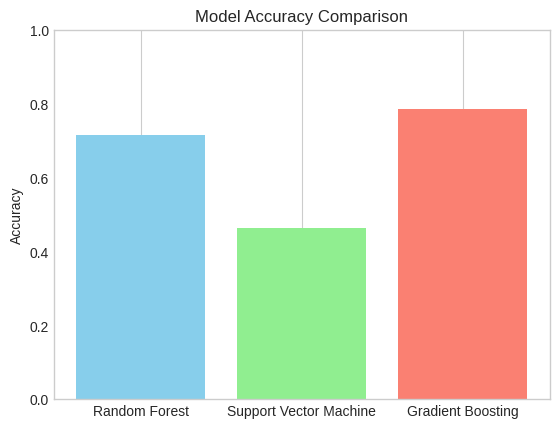

In [ ]:
import matplotlib.pyplot as plt

plt.bar(results.keys(), results.values(), color=["skyblue", "lightgreen", "salmon"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [ ]:
print("X_train_aug_scaled:", X_train_aug_scaled.shape)
print("y_train_aug:", y_train_aug.shape)
print("X_test_aug_scaled:", X_test_aug_scaled.shape)


X_train_aug_scaled: (82, 98)
y_train_aug: (82,)
X_test_aug_scaled: (28, 98)


In [ ]:
print("y_pred:", y_pred.shape)



y_pred: (1,)


In [ ]:
print("Type of X_test_aug_scaled:", type(X_test_aug_scaled))
print("Shape:", X_test_aug_scaled.shape)

# Predict
y_pred = model.predict(X_test_aug_scaled)
print("y_pred shape:", y_pred.shape)  # Should be (28,)


Type of X_test_aug_scaled: <class 'numpy.ndarray'>
Shape: (28, 98)
y_pred shape: (28,)


# Confusion matrix for Randomforest classifier

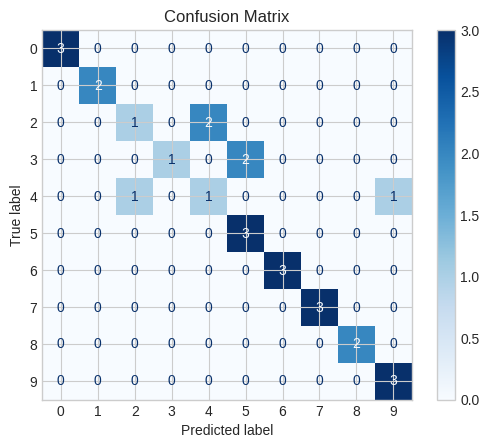

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_aug, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


Gradient Boosting Accuracy: 0.7857


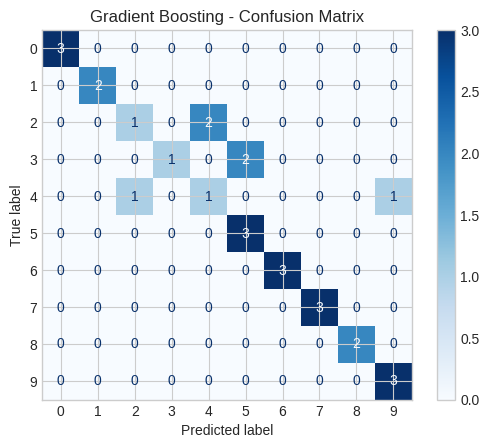

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# 1. Train the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_aug_scaled, y_train_aug)

# 2. Predict on test set
y_pred_gb = gb_model.predict(X_test_aug_scaled)

# 3. Print accuracy
accuracy = accuracy_score(y_test_aug, y_pred_gb)
gradient_boosting_accuracy = accuracy
print(f"Gradient Boosting Accuracy: {accuracy:.4f}")

# 4. Generate and display confusion matrix
cm_gb = confusion_matrix(y_test_aug, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=np.arange(10))
disp.plot(cmap='Blues')
plt.title("Gradient Boosting - Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_aug, y_pred_gb))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       0.50      0.33      0.40         3
           3       1.00      0.33      0.50         3
           4       0.33      0.33      0.33         3
           5       0.60      1.00      0.75         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       0.75      1.00      0.86         3

    accuracy                           0.79        28
   macro avg       0.82      0.80      0.78        28
weighted avg       0.81      0.79      0.77        28



HYPER PARAMETER TUNING

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
gb_model = GradientBoostingClassifier(random_state=42)

# Define hyperparameters to try
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

# Define the grid search
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=5,                  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,             # Use all CPU cores
    verbose=2
)

# Run the search
grid_search.fit(X_train_aug_scaled, y_train_aug)

# Best results
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Use the best model
best_gb_model = grid_search.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
Best Cross-Validation Accuracy: 0.6838235294117647


Test Accuracy: 0.75


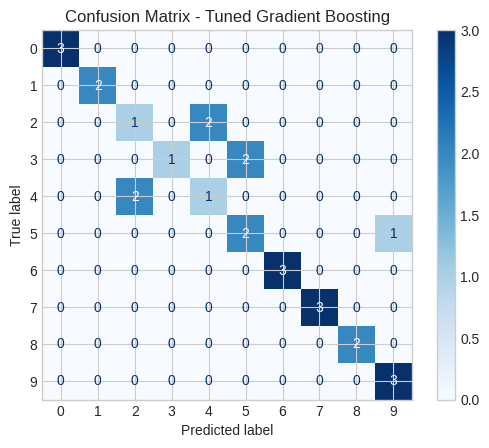

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

y_pred_best = best_gb_model.predict(X_test_aug_scaled)
tuned_gradient_boosting_accuracy = accuracy_score(y_test_aug, y_pred_best)
print("Test Accuracy:", tuned_gradient_boosting_accuracy)

# Confusion Matrix
cm = confusion_matrix(y_test_aug, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Tuned Gradient Boosting")
plt.show()


Test Accuracy (Tuned Gradient Boosting): 0.75


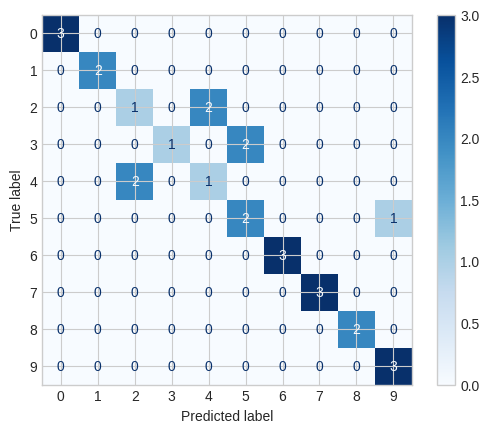

In [ ]:
best_model = grid_search.best_estimator_

# Predict on test set
y_pred_best = best_model.predict(X_test_aug_scaled)

# Evaluate
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
acc = accuracy_score(y_test_aug, y_pred_best)
print("Test Accuracy (Tuned Gradient Boosting):", acc)

# Visualize confusion matrix
cm = confusion_matrix(y_test_aug, y_pred_best)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")


# XG boost

In [ ]:
!pip install xgboost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:39:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.6429


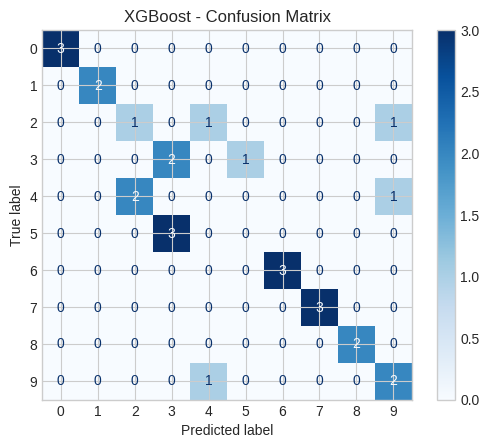

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Initialize the model
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    objective='multi:softmax',  # for multiclass classification
    num_class=10,               # total number of output classes
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# 2. Train the model
xgb_model.fit(X_train_aug_scaled, y_train_aug)

# 3. Predict on test set
y_pred_xgb = xgb_model.predict(X_test_aug_scaled)

# 4. Evaluate accuracy
accuracy = accuracy_score(y_test_aug, y_pred_xgb)
xg_boost_accuracy = accuracy
print(f"XGBoost Accuracy: {accuracy:.4f}")

# 5. Confusion Matrix
cm = confusion_matrix(y_test_aug, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("XGBoost - Confusion Matrix")
plt.show()


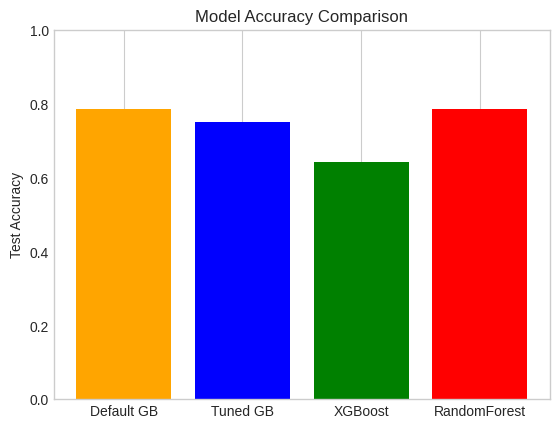

In [ ]:
models = ['Default GB', 'Tuned GB', 'XGBoost',"RandomForest"]
accuracies = [gradient_boosting_accuracy, tuned_gradient_boosting_accuracy, xg_boost_accuracy,random_forest_accuracy]  # Replacing with  actual numbers

plt.bar(models, accuracies, color=['orange', 'blue', 'green','red'])
plt.ylabel('Test Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()
